# Analisi dati di allenamento Garmin

Disponendo di un ampio dataset con oltre 75.000 registrazioni provenienti da un dispositivo Garmin (Edge 820), relative ad allenamenti in bicicletta, l'obiettivo è sviluppare modelli predittivi basati su alcuni parametri (come la velocità, la pendenza, ecc.) per prevedere alcuni parametri di interesse.
- *Regressione*:
    - predire il battito cardiaco istantaneo (bpm)
    - predire la potenza istantanea (W)
- *Classificazione*:
    - classificare la zona di frequenza cardiaca
    - classificare la zona di potenza

## Raccolta dei dati
Poiché i dati non sono stati raccolti da siti noti come [UCI](https://archive.ics.uci.edu/), [Kaggle](https://www.kaggle.com/), ecc. bensì da allenamenti svolti personalmente da Riccardo Fiorani, è stato necessario estrarre i dati dai file *.fit* e *.tcx* messi a disposizione da Garmin e convertirli in *.csv* in modo da poterli analizzare con Python.
Per fare questo si è utilizzato il tool [Fit File Repair Tool](https://www.fitfilerepairtool.info/), che permette di convertire i file *.fit* in *.csv*.
Aggiungi ulteriore descrizione....

## Descrizione dei dati
Non essendo i dati provenienti da un dataset noto, è necessario descriverli in modo da poterli analizzare e comprendere meglio.
I *CSV* e i formati originali sono visionabili nella cartella del progetto `garmin_edge_820/`.
In particolare il dataset utilizzato è dato dall'unione di 4 allenamenti, ciascuno relativo a un allenamento.
Ogni record rappresenta un istante di un dato allenamento, raccolto con cadenza di un secondo, e contiene le seguenti informazioni:
- `timestamp`: data e ora dell'istante
- `distance`: distanza percorsa dall'inizio dell'allenamento (m)
- `accumulated_power`: potenza accumulata da inizio allenamento (W)
- `altitude`: altitudine (m)
- `speed`: velocità istantanea (m/s)
- `power`: potenza istantanea (W)
- `heart_rate`: frequenza cardiaca (bpm)
- `cadence`: cadenza di pedalata (rpm)
- `temperature`: temperatura (°C)
- `left_right_balance`: bilanciamento destro/sinistro, corrisponde alla percentuale di potenza applicata dal piede destro in rapporto a quella applicata dal piede sinistro. 
- `left_pco`: parametro Garmin che indica la distribuzione della forza lungo la battuta del pedale durante la pedalata. In questo caso relativo al piede sinistro. Il PCO si misura in millimetri. Valori positivi (ad es. +6 mm) indicano una forza maggiore verso l'esterno del pedale, mentre valori negativi (ad es. -4 mm) indicano una maggiore forza verso l'interno del pedale. Si veda la seguente immagine per ulteriori informazioni
<div align="center"><img src="imgs/pco.png" width="200"></div>

- `right_pco`: come sopra ma relativo al piede destro.
- `left_power_phase`: I sensori di potenza Garmin rilevano il punto in cui la gamba genera una coppia positiva in una pedalata e dove si verifica la maggiore concentrazione di coppia positiva. Inoltre, rilevano l'angolo a cui queste forze iniziano e terminano e il punto in cui si produce la concentrazione di potenza.
<div align="center"><img src="imgs/pwrphase.png" width="200"></div>

- `left_power_phase_peak`: picco massimo di power phase sinistra.
- `right_power_phase`: power phase destro.
- `right_power_phase_peak`: picco massimo di power phase destra.

A questi parametri sono stati aggiunti altri parametri derivati, come:
- `time_since_start`: tempo trascorso dall'inizio dell'allenamento (s). Volevamo verificare se vi è una correlazione fra tempo trascorso e frequenza cardiaca, potenza, ecc.
- `hr_zone`: zona di frequenza cardiaca. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 128)
    - Zona 2: (129, 146)
    - Zona 3: (147, 156)
    - Zona 4: (157, 165)
    - Zona 5: (166, 174)
    - Zona 6: (175, 179)
    - Zona 7: $\geq$ 180
- `pwr_zone`: zona di potenza. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 157)
    - Zona 2: (158, 186)
    - Zona 3: (187, 200)
    - Zona 4: (201, 218)
    - Zona 5: (219, 247)
    - Zona 6: (248, 287)
    - Zona 7: $\geq$ 288
- `altitude_diff`: differenza di altitudine rispetto al secondo precedente (m)
- `distance_diff`: differenza di distanza rispetto al secondo precedente (m)
- `slope_percent`: pendenza istantanea (%), calcolata come 
$$
\frac{\text{\texttt{altitude\_diff}}}{\text{\texttt{distance\_diff}}}
$$

In totale il dataset è composto da 77.620 record.

## Preparazione dei dati

Di seguito sono riportate le operazioni di preparazione dei dati effettuate prima di procedere con l'analisi vera e propria.

In [31]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install lightgbm
%pip install xgboost
%pip install flask
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tens

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\ricca\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
file_list = ["garmin_edge_820/3993730634_ACTIVITY_data.csv",
             "garmin_edge_820/4557226804_ACTIVITY_data.csv",
             "garmin_edge_820/4593452980_ACTIVITY_data.csv",
             "garmin_edge_820/5191513011_ACTIVITY_data.csv",
]
combined_df = pd.concat([pd.read_csv(file, sep=";") for file in file_list], ignore_index=True)

In [102]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65344 entries, 0 to 65343
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp[s]                     65344 non-null  int64  
 1   distance[m]                      65344 non-null  float64
 2   altitude[m]                      65344 non-null  float64
 3   speed[m/s]                       65332 non-null  float64
 4   power[watts]                     65344 non-null  int64  
 5   heart_rate[bpm]                  65344 non-null  int64  
 6   temperature[C]                   65344 non-null  int64  
 7   cadence[rpm]                     65344 non-null  int64  
 8   accumulated_power[watts]         65344 non-null  int64  
 9   left_pco[mm]                     65344 non-null  int64  
 10  right_pco[mm]                    65344 non-null  int64  
 11  right_power_phase[degrees]       65344 non-null  object 
 12  right_power_phase_

Poiché alcuni modelli (LGBM Regressor) non supportano features aventi caratteri non unicode, abbiamo sostituito le parentesi quadre con delle tonde usando il metodo `convert_brackets`

In [103]:
def convert_brackets(string):
    return string.replace('[', '(').replace(']', ')')

combined_df.columns = [convert_brackets(col) for col in combined_df.columns]

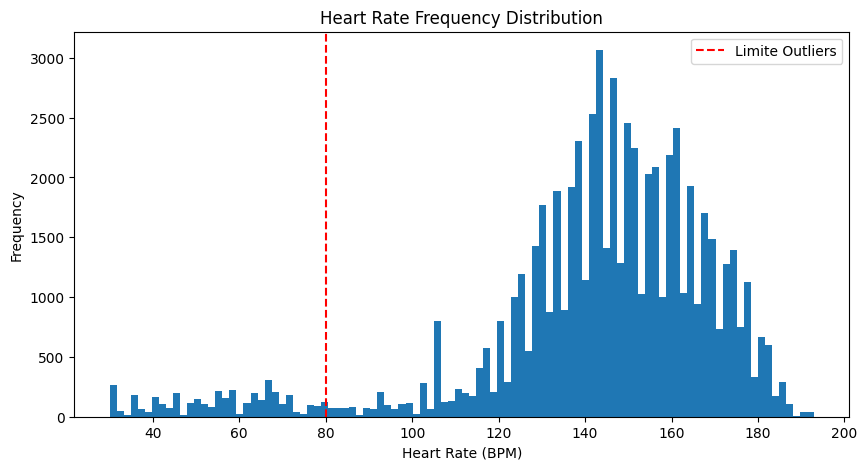

In [104]:
plt.figure(figsize=(10, 5))

plt.hist(combined_df['heart_rate(bpm)'], bins=100)

plt.title("Heart Rate Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Heart Rate (BPM)")

plt.axvline(x=80, color='red', linestyle='--', label='Limite Outliers')  
plt.legend()

plt.show()

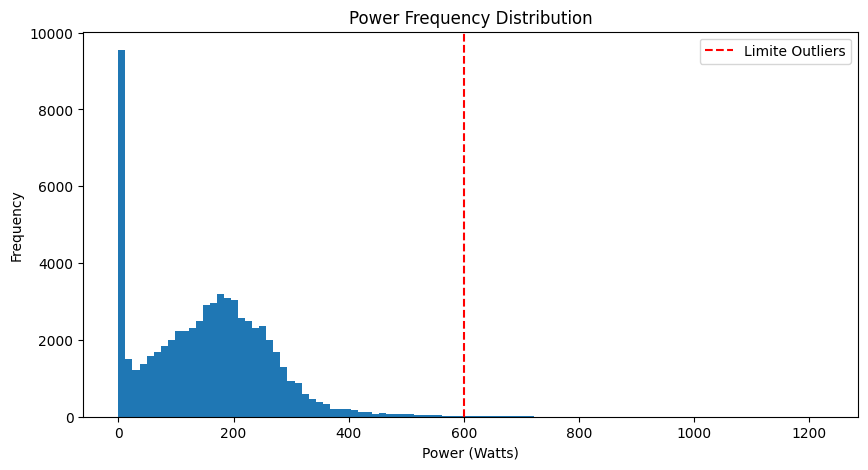

In [105]:
plt.figure(figsize=(10, 5))

plt.hist(combined_df['power(watts)'], bins=100)

plt.title("Power Frequency Distribution")
plt.ylabel("Frequency")
plt.xlabel("Power (Watts)")

plt.axvline(x=600, color='red', linestyle='--', label='Limite Outliers') 
plt.legend()

plt.show()

Per questioni di errore di misurazione, abbiamo visto che alcuni record presentano valori di `speed(m/s)`, `power(watts)`, e di `cadence(rpm)` uguali a 0. Non essendo quei record rilevanti per l'analisi, abbiamo deciso di eliminarli. Inoltre, come mostrato nel `combined_df.info()` superiore, esistono molti valori di `speed(m/s)` posti a `NaN`. Abbiamo deciso di eliminare anche questi record.

La misurazione del battito cardiaco è molto imprecisa su valori bassi. Poiché è altamente iprobabile aver raggiunto 30 bpm durante un allenamento, abbiamo deciso di eliminare i record con frequenza cardiaca inferiore ad una soglia che, visionando il grafico precedente, abbiamo deciso di porre a 80bpm.

Per quanto riguarda la previsione della potenza, essendo molto lontani dalla frequenza media di tutti gli allenamenti, sono stati scartati i valori oltre ai 600 watts.

In [106]:
combined_df = combined_df[combined_df['speed(m/s)'] > 0]
combined_df = combined_df[(combined_df['power(watts)'] > 0) & (combined_df['power(watts)'] < 600)]
combined_df = combined_df[combined_df['cadence(rpm)'] > 0]
combined_df = combined_df[combined_df['heart_rate(bpm)'] > 80]
combined_df = combined_df.dropna(subset=['speed(m/s)'])

Di seguito è invece implementata una funzione che genera le zone di frequenza cardiaca e di potenza.

In [107]:
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165),(166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218),(219, 247), (248, 287), (288, float('inf'))]

def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return zone
        
combined_df['hr_zone'] = combined_df['heart_rate(bpm)'].apply(get_zone, zones=hr_zones)
combined_df['pwr_zone'] = combined_df['power(watts)'].apply(get_zone, zones=power_zones)

A questo punto si calcolano le features relative alla differenza di altitudine e distanza dall'istante successivo. Successivamente vengono utilizzate per calcolare la pendenza istantanea.

In [108]:
combined_df['altitude_diff(m)'] = combined_df['altitude(m)'] - combined_df['altitude(m)'].shift(1)
combined_df['distance_diff(m)'] = combined_df['distance(m)'] - combined_df['distance(m)'].shift(1)
combined_df[['altitude_diff(m)', 'distance_diff(m)']] = combined_df[['altitude_diff(m)', 'distance_diff(m)']].fillna(0)
combined_df['slope_percent'] = np.where(combined_df['distance_diff(m)'] == 0, 0, combined_df['altitude_diff(m)'] / combined_df['distance_diff(m)'] * 100)

Anche la potenza, come mostrato nel grafico precedente, presenta valori molto instabili. In particolare si notano
- molti buchi, cioè linee rette nel grafico, che indicano che il sensore non ha rilevato la potenza
- picchi molto alti susseguiti da picchi molto bassi. Questo è dovuto al fatto che il sensore di potenza è molto sensibile e rileva anche piccole variazioni di potenza.

Per questo motivo abbiamo deciso di calcolare la media mobile con finestra di 3 secondi. Questo ci permette di avere una visione più chiara della potenza durante l'allenamento.

In [109]:
window_size = 6
combined_df['avg_power(watts)'] = combined_df['power(watts)'].rolling(window=int(window_size), center=True).mean()
combined_df = combined_df.dropna(subset=['avg_power(watts)'])
combined_df['avg_power(watts)'] = combined_df['avg_power(watts)'].astype('int64')


Il parametro `left_right_balance` di Garmin va trattato per visualizzare l'effettiva potenza di spinta da gamba sinistra e destra. In particolare Garmin suggerisce di usare la seguente formula
$$
\text{\texttt{left\_power}} = \text{\texttt{left\_right\_balance}} - 128 \\
\text{\texttt{right\_power}} = 100 - \text{\texttt{left\_power}}
$$


Poiché alcuni modelli (LGBM Regressor) non supportano features aventi caratteri non unicode, abbiamo sostituito le parentesi quadre con delle tonde usando il metodo `convert_brackets`

In [110]:
combined_df['power_left(watts)'] = combined_df['left_right_balance'] - 128
combined_df['power_right(watts)'] = 100 - combined_df['power_left(watts)']

A questo punto abbiamo deciso di sostituire la colonna `timestamp(s)` in un formato più comodo da gestire, ovvero `datetime`. Per fare questo abbiamo usato il metodo Pandas `to_datetime`. A questo punto abbiamo reso la colonna risultante `time` l'indice del DataFrame.

In [111]:
combined_df['timestamp(s)'] = combined_df['timestamp(s)'] + 631065600
combined_df['time'] = pd.to_datetime(combined_df.pop('timestamp(s)'), unit='s')
combined_df.set_index("time", inplace=True)

Come anticipato nella sezione precedente, abbiamo aggiunto una feature `time_since_start(s)` che indica il tempo trascorso dall'inizio dell'allenamento. 

In [112]:
combined_df['time_since_start(s)'] = combined_df.groupby(pd.Grouper(freq='D')).cumcount() + 1

In [113]:
def plot_data_vs_time(col):
    grouped_df = combined_df.groupby(combined_df.index.date)
    fig, ax = plt.subplots(nrows=len(grouped_df), sharex=True, figsize=(24, 9))
    for i, (date, data) in enumerate(grouped_df):
        ax[i].plot(data["time_since_start(s)"], data[col], label=str(date))

    fig.legend()

    fig.text(0.5, 0.04, "Time since Start", ha="center")
    fig.text(0.04, 0.5, col, va="center", rotation="vertical")
    plt.suptitle(f"{col} vs Time since Start for Each Training Day")

    plt.show()

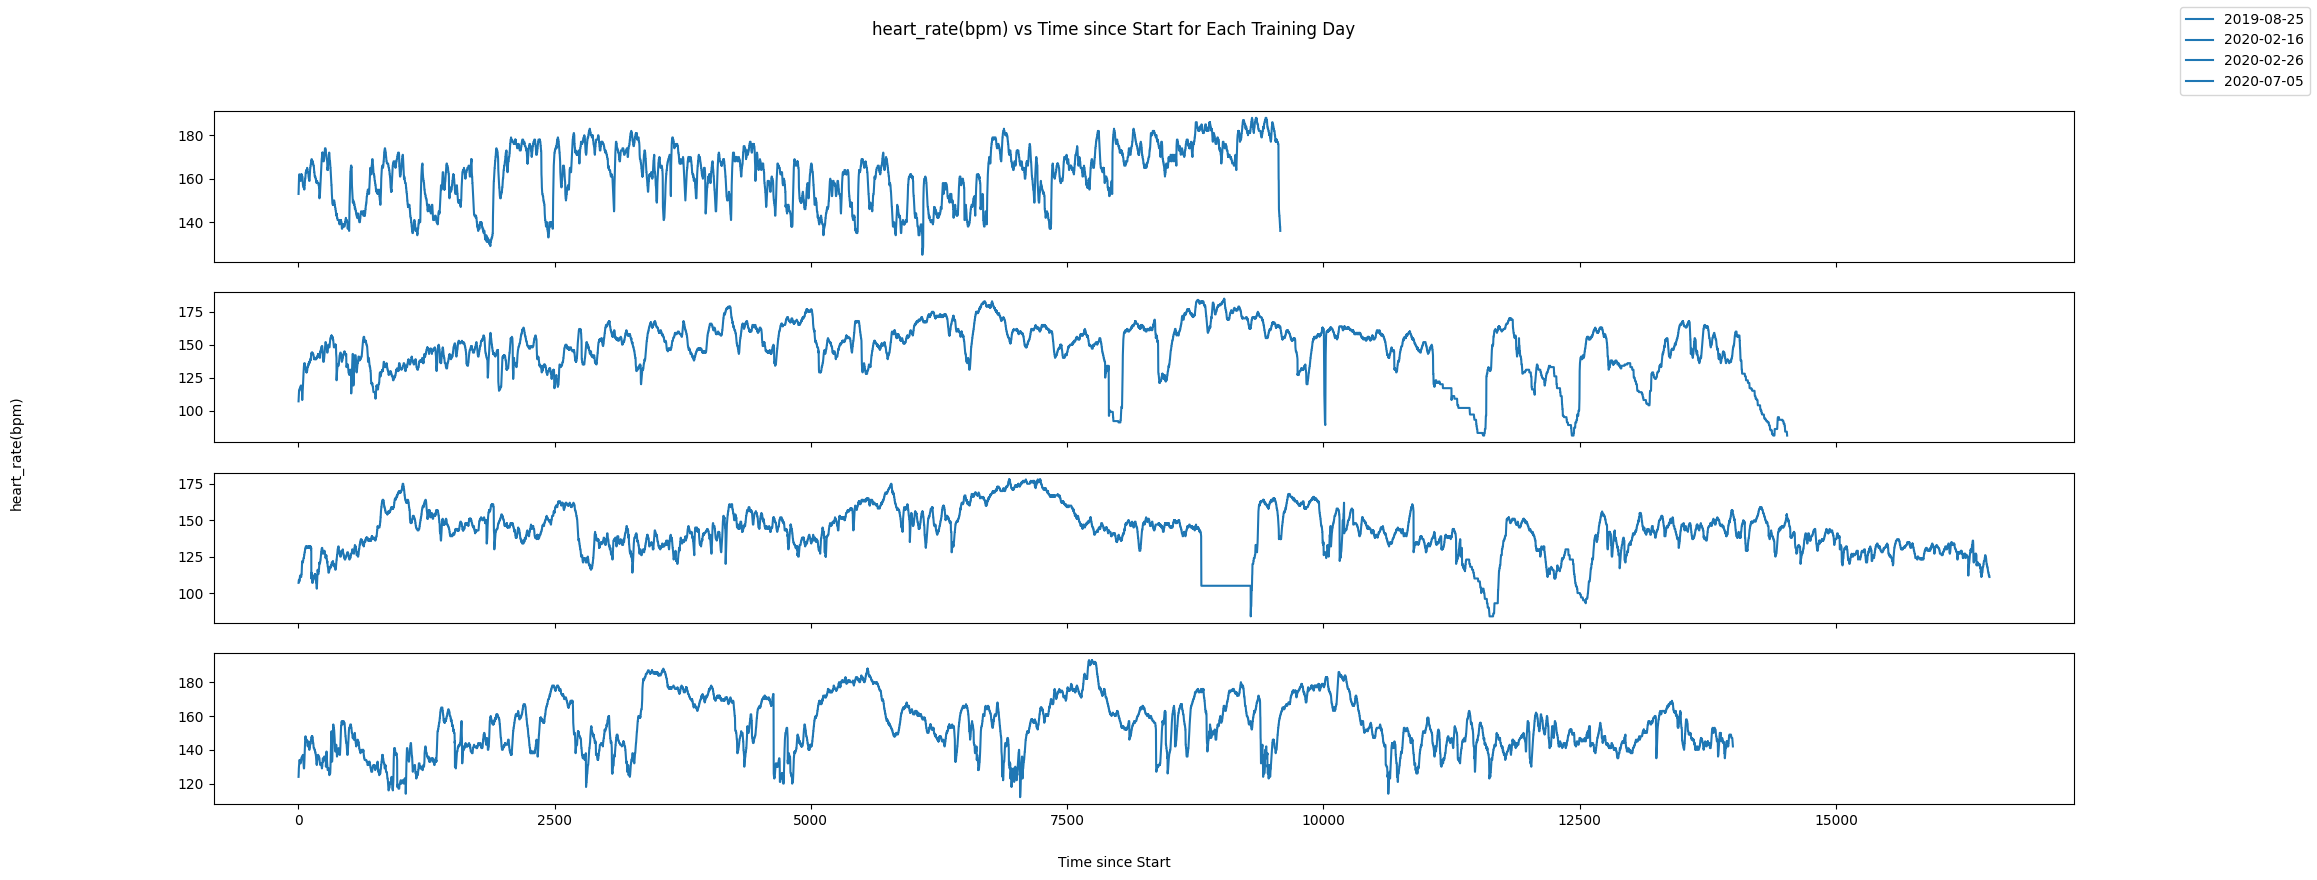

In [114]:
plot_data_vs_time('heart_rate(bpm)')

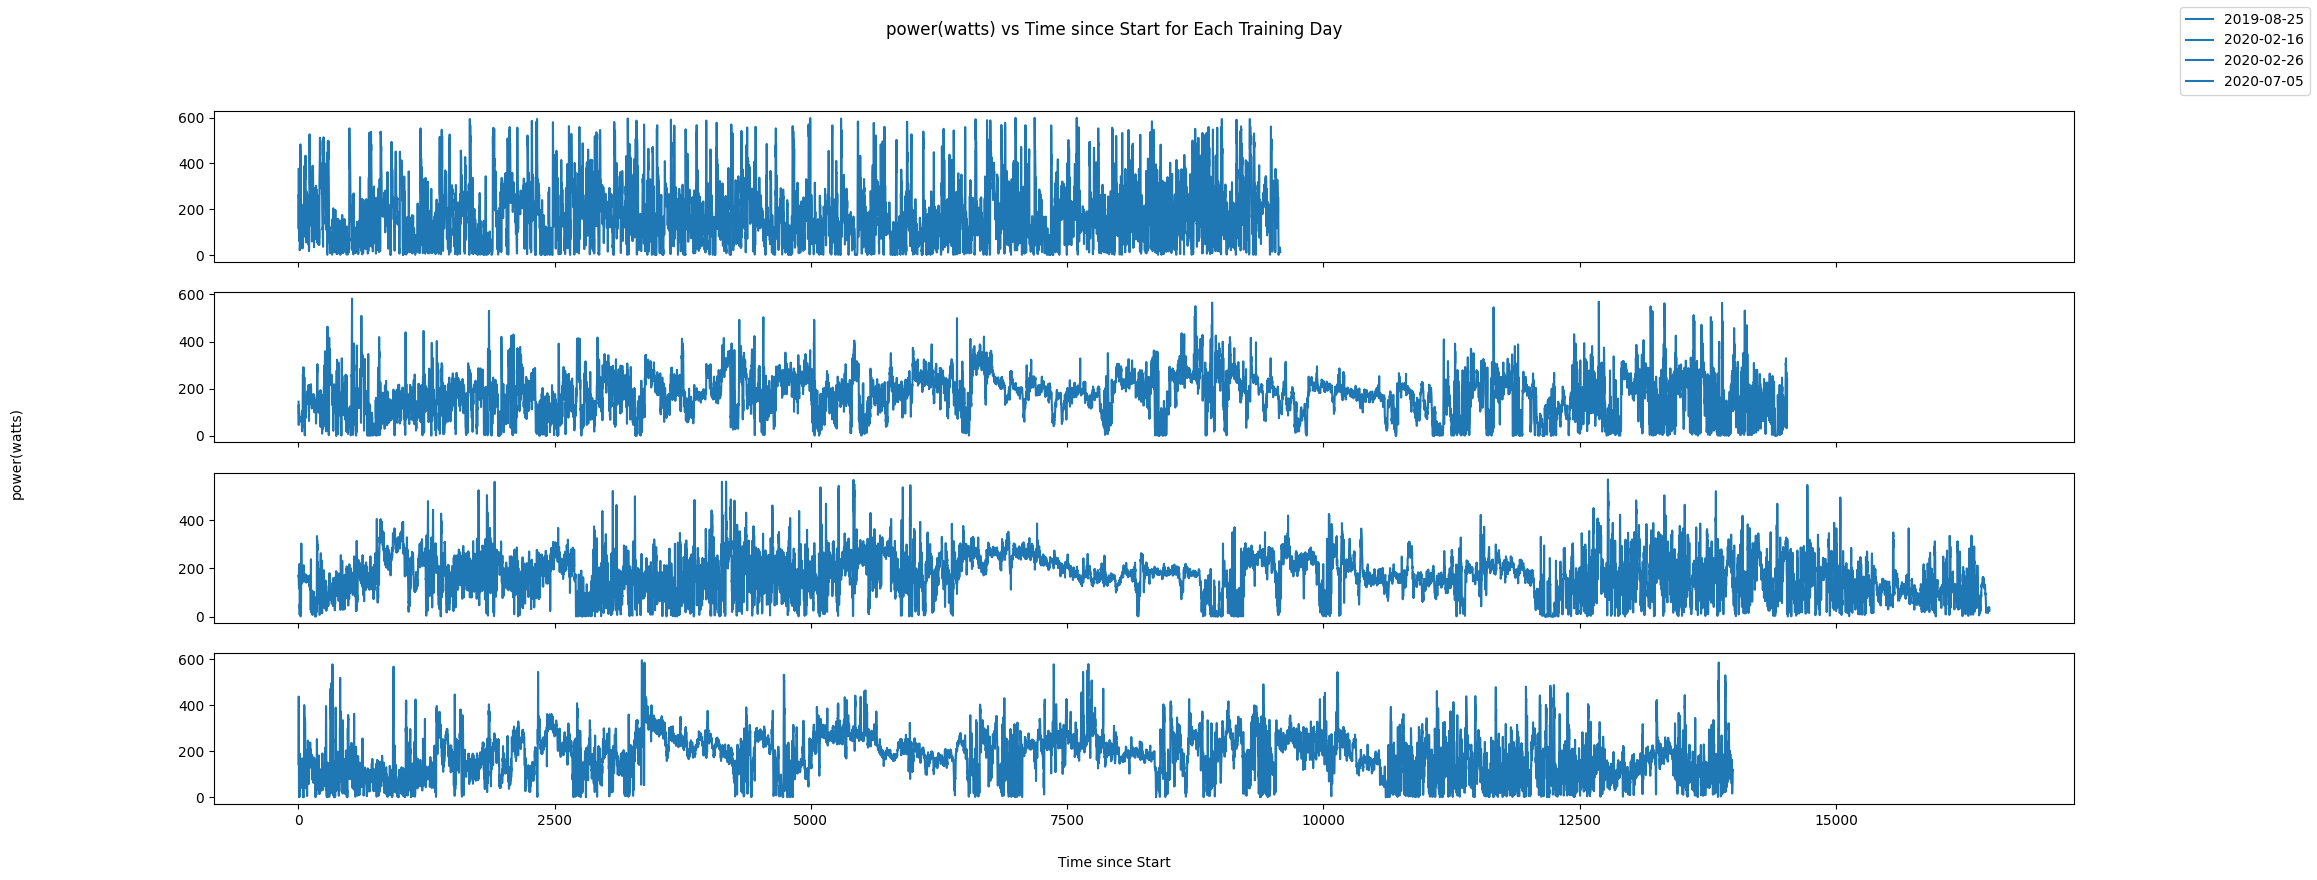

In [115]:
plot_data_vs_time('power(watts)')

Come ultima cosa vengono rimosse quelle feature inutilizzate per l'analisi.
- `left_right_balance`: non è più necessaria poiché abbiamo calcolato `left_power` e `right_power`
- `left_power_phase_peak`: non è necessario il picco se abbiamo il valore istantaneo
- `right_power_phase_peak`: come sopra
- `left_power_phase`: (***ANCORA DA CALCOLARE***)
- `right_power_phase`: (***ANCORA DA CALCOLARE***)

In [116]:
combined_df = combined_df.drop(['left_power_phase(degrees)',
                            'left_power_phase_peak(degrees)',
                            'right_power_phase(degrees)',
                            'right_power_phase_peak(degrees)',
                            'left_right_balance'], axis=1)

In [117]:
combined_df.describe()

distance(m)   altitude(m)    speed(m/s)  power(watts)  \
count   54596.000000  54596.000000  54596.000000  54596.000000   
mean    64509.924578    252.155858      8.531135    174.085006   
std     37985.823152    265.048895      3.382565     97.612084   
min         6.790000      3.200000      0.370000      1.000000   
25%     33434.352500     57.000000      5.740000    105.000000   
50%     63892.200000    119.000000      9.070000    174.000000   
75%     91778.855000    407.600000     10.990000    236.000000   
max    151811.360000   1112.800000     18.140000    599.000000   

       heart_rate(bpm)  temperature(C)  cadence(rpm)  \
count     54596.000000    54596.000000  54596.000000   
mean        149.570994       19.839805     85.410085   
std          18.661042        8.143618     16.603334   
min          81.000000        5.000000      4.000000   
25%         139.000000       14.000000     80.000000   
50%         150.000000       16.000000     89.000000   
75%         163.000000       30.000000     95.000000   
max         193.000000       34.000000    142.000000   

       accumulated_power(watts)  left_pco(mm)  right_pco(mm)       hr_zone  \
count              5.459600e+04  54596.000000   54596.000000  54596.000000   
mean               1.270795e+06     -4.061946      -0.943201      3.167906   
std                7.957466e+05      5.978991       4.171813      1.548506   
min                3.340000e+02   -123.000000     -98.000000      1.000000   
25%                5.709218e+05     -7.000000      -3.000000      2.000000   
50%                1.232716e+06     -5.000000      -1.000000      3.000000   
75%                1.955029e+06     -2.000000       1.000000      4.000000   
max                2.871844e+06    123.000000     126.000000      7.000000   

           pwr_zone  altitude_diff(m)  distance_diff(m)  slope_percent  \
count  54596.000000      54596.000000      54596.000000   54596.000000   
mean       3.019745         -0.000476          2.401007       1.808858   
std        2.222452          1.131614       1032.181294       4.603025   
min        1.000000       -115.000000    -151785.510000     -52.238806   
25%        1.000000          0.000000          5.770000       0.000000   
50%        2.000000          0.000000          9.100000       0.000000   
75%        5.000000          0.200000         11.120000       3.334725   
max        7.000000         46.800000       6205.460000      62.639821   

       avg_power(watts)  power_left(watts)  power_right(watts)  \
count      54596.000000       54596.000000        54596.000000   
mean         173.672320          50.337387           49.662613   
std           83.774326          11.617998           11.617998   
min            1.000000           0.000000            0.000000   
25%          112.000000          48.000000           47.000000   
50%          172.000000          50.000000           50.000000   
75%          229.000000          53.000000           52.000000   
max          551.000000         100.000000          100.000000   

       time_since_start(s)  
count         54596.000000  
mean           7059.147575  
std            4289.510229  
min               1.000000  
25%            3413.000000  
50%            6825.000000  
75%           10456.250000  
max           16498.000000

In [118]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54596 entries, 2019-08-25 12:05:10 to 2020-07-05 10:23:29
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance(m)               54596 non-null  float64
 1   altitude(m)               54596 non-null  float64
 2   speed(m/s)                54596 non-null  float64
 3   power(watts)              54596 non-null  int64  
 4   heart_rate(bpm)           54596 non-null  int64  
 5   temperature(C)            54596 non-null  int64  
 6   cadence(rpm)              54596 non-null  int64  
 7   accumulated_power(watts)  54596 non-null  int64  
 8   left_pco(mm)              54596 non-null  int64  
 9   right_pco(mm)             54596 non-null  int64  
 10  hr_zone                   54596 non-null  int64  
 11  pwr_zone                  54596 non-null  int64  
 12  altitude_diff(m)          54596 non-null  float64
 13  distance_diff(m)          

# Data Visualization

Di seguito sono riportati i grafici che mostrano la distribuzione delle features. Per avere una visione più chiara si è deciso di dividere le misurazioni in base all'allenamento.

In [119]:
def plot_params_per_training(params):
    grouped_df = combined_df.groupby(combined_df.index.date)

    fig, axs = plt.subplots(nrows=len(grouped_df), figsize=(21, 10), sharex=True)

    for i, (date, data) in enumerate(grouped_df):
        axs[i].set_title(str(date))

        for param in params:
            axs[i].plot(data["time_since_start(s)"], data[param], label=param)

        axs[i].legend()
        axs[i].grid(True)

    plt.xlabel("time_since_start")
    plt.suptitle("Data vs Time since Start for Each Training Day")
    plt.show()

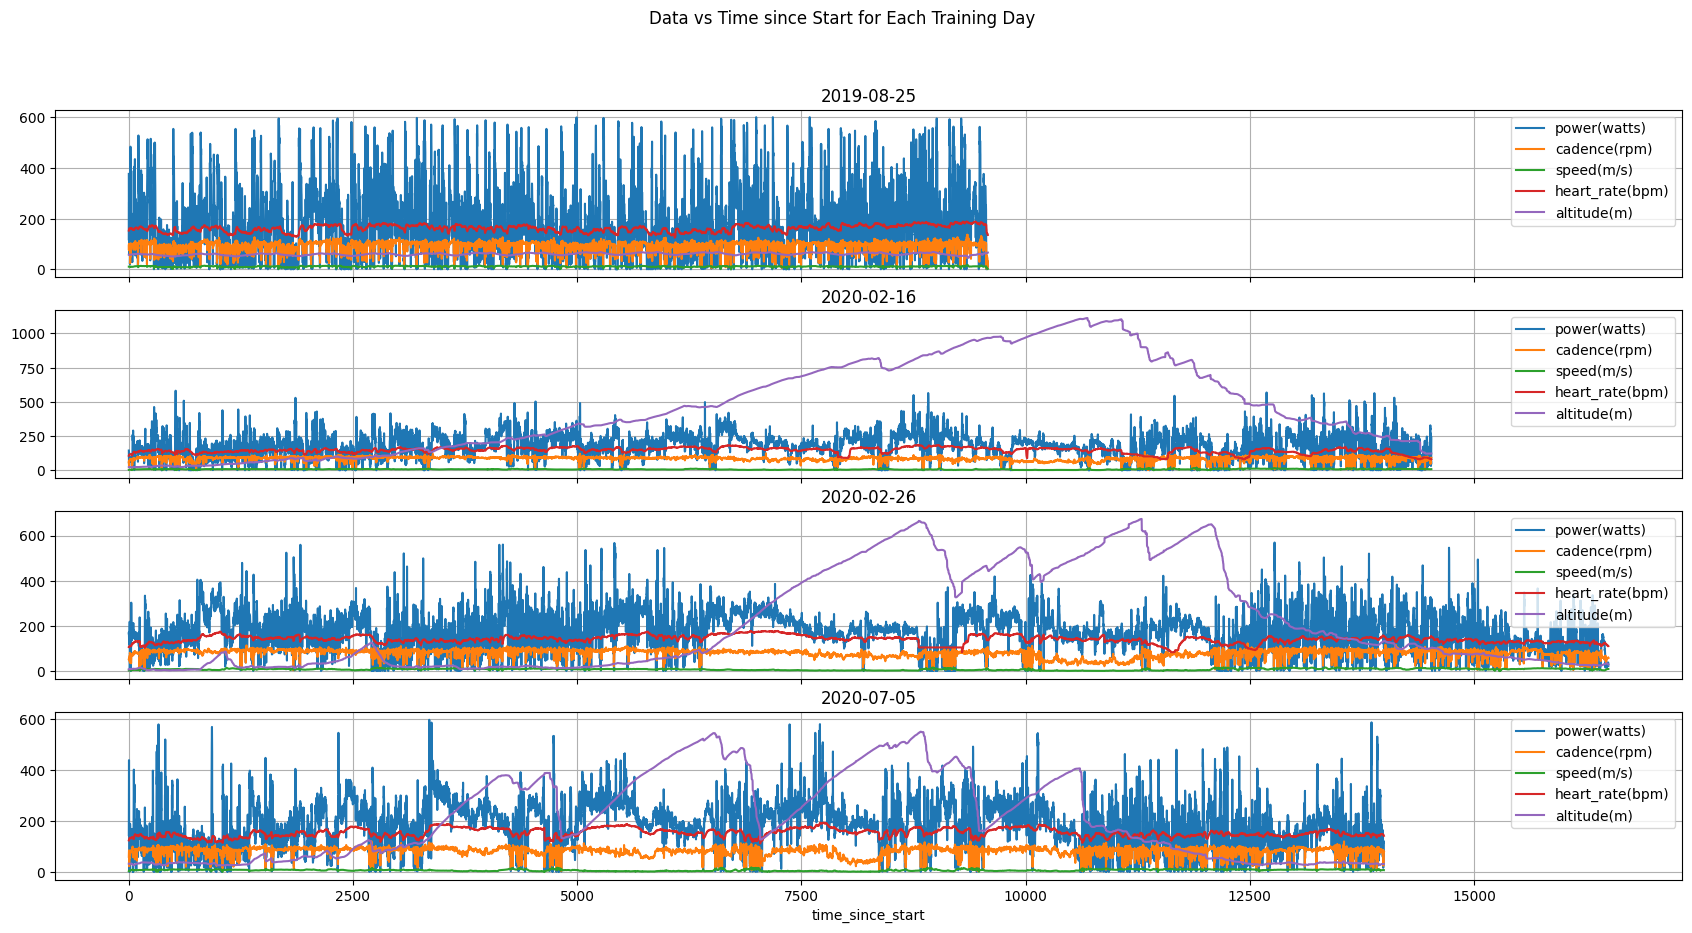

In [120]:
plot_params_per_training(['power(watts)', 'cadence(rpm)', 'speed(m/s)', 'heart_rate(bpm)', 'altitude(m)'])

# Previsioni

In [121]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Di seguito sono riportati i modelli utilizzati per le previsioni. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Abbiamo deciso di provare diversi modelli per capire quale fosse il migliore per il nostro dataset. In particolare abbiamo provato i seguenti modelli:
- Modelli lineari
    - *Linear Regression*
    - *Ridge Regression*
    - *Lasso Regression*
    - *Elastic Net*
- Modelli Kernel
    - *KernelRidge*
- Modelli ad albero
    - *Decision Tree Regressor*
    - *Random Forest Regressor*
    - *XGBoost Regressor*
    - *LightGBM Regressor*
    
Per ciascuno di essi abbiamo fatto un tuning degli iperparametri per ottenere i migliori risultati possibili.

In [122]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Definizione dei modelli

Per l'addestramento abbiamo deciso di utilizzare la cross validation con 5 fold. Inoltre abbiamo deciso di aggregare tutte le pipeline in un unico dizionario per poterle richiamare più facilmente.
Con il metodo `get_pipe_grid(type)` si restituisce l'opportuna pipeline e il dizionario di iperparametri da utilizzare per il tuning. Il parametro `type` può assumere i seguenti valori:
- `linear`: modelli lineari
- `kernel`: modelli kernel
- `tree`: modelli ad albero

In [123]:
def get_pipe_grid(type):
    pipelines = {
        "linear": {
            "pipe": Pipeline([
                ("poly", PolynomialFeatures(include_bias=False)),
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "poly__degree": [3, 4, 5],
                "std": [StandardScaler()],
            },
            "grid_regressors": [
                {
                    "regressor": [LinearRegression()],
                },
                {
                    "regressor": [ElasticNet()],
                    "regressor__alpha": [0.01, 0.1, 1],
                    "regressor__l1_ratio": [0.0, 0.5, 1.0],
                },
            ]
        },
        "kernel": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor": [KernelRidge()],
                'regressor__alpha': [0.1],
            },
            "grid_regressors": [
                {
                    "regressor__kernel": ["poly"],
                    'regressor__degree': [3],
                },
                {
                    "regressor__kernel": ["rbf"],
                    "regressor__gamma": [0.1],
                }
            ]
        },
        "tree": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor__max_depth": [5,10,15],
            },
            "grid_regressors": [
                {
                    "regressor": [DecisionTreeRegressor()],
                },
                {
                    "regressor": [RandomForestRegressor()],
                    "regressor__n_estimators": [100,1000],
                },
                {
                    "regressor": [LGBMRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                },
                {
                    "regressor": [XGBRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                }
            ]
        }
    }
    return pipelines[type]["pipe"], [dict(pipelines[type]["grid_common"], **params) for params in pipelines[type]["grid_regressors"]]

Attraverso il metodo `get_trained_model(type, X_train, y_train, randomized)` ci consente di restituire il miglior modello addestrato fra tutti quelli provati attraverso la grid/randomized search.
Il metodo ha i seguenti parametri:
- `type`: tipo di modello da addestrare, i valori assunti sono gli stessi del metodo precedente. Serve infatti per richiamare il metodo `get_pipe_grid(type)`
- `X_train`: training set
- `y_train`: target set
- `randomized`: booleano che indica se utilizzare la *grid search* o la *randomized search*

In [124]:
def get_trained_model(type, X_train, y_train):
    pipe, grid = get_pipe_grid(type)
    model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
    model.fit(X_train, y_train)
    return model

In [125]:
import utilities
from utilities import print_eval


## Previsione battito

In questa sezione vengono riportati i modelli utilizzati per la previsione del battito cardiaco. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Come prima cosa costruiamo il training set `X_hr` droppando dal dataset i parametri non necessari.
In particolare abbiamo deciso di droppare, fra le altre, anche `hr_zone`, questo perché in una prima versione del codice, i modelli addestrati, come ci si poteva aspettare, davano troppa importanza a questa feature, trascurando le altre. Essendoci una troppo alta correlazione fra `hr_zone` e `heart_rate(bmp)`, abbiamo deciso di droppare `hr_zone` per evitare questo problema.

In [126]:
X_hr = combined_df.drop(['heart_rate(bpm)','distance(m)','altitude(m)','speed(m/s)','avg_power(watts)','time_since_start(s)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_hr = combined_df['heart_rate(bpm)']
X_train, X_val, y_train, y_val = train_test_split(X_hr, y_hr, test_size=1/3, random_state=42)

### Regressione lineare

Con modelli di regressione lineare si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto tramite una Grid Search.

In [59]:
liner_models_gs = get_trained_model('linear', X_train, y_train)
linear_models_gs_res = pd.DataFrame(liner_models_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, liner_models_gs)
linear_models_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.146e+06, tolerance: 1.011e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality

   Mean squared error:       271.48
       Relative error:     8.84989%
R-squared coefficient:      0.22415


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2        0.017725      0.001386         0.002201    5.093048e-04   
1        0.011508      0.000547         0.001920    3.814219e-04   
23       3.419537      0.047843         0.002499    4.101908e-07   
0        0.011243      0.002374         0.001957    5.549375e-04   
14       2.748497      0.070824         0.002159    3.157207e-04   
22       3.768318      0.067212         0.002577    4.416313e-04   
5        1.930876      0.017856         0.001802    2.459171e-04   
21       4.242232      0.057930         0.002602    3.736093e-04   
13       2.673617      0.042322         0.002201    2.453613e-04   
12       2.938971      0.060855         0.002301    2.459069e-04   
4        1.892080      0.030577         0.001700    2.449910e-04   
26       0.957329      0.503097         0.002201    2.442703e-04   
17       0.303703      0.007704         0.001600    3.745601e-04   
25       0.595820      0.017960         0.002400    3.743426e-04   
3        1.918213      0.020846         0.001701    2.468836e-04   
24       4.190885      0.044695         0.002418    2.117229e-04   
16       0.499966      0.028125         0.002016    3.168926e-04   
8        0.564683      0.028118         0.001801    2.436465e-04   
15       3.026117      0.062007         0.002000    1.087356e-06   
7        0.183994      0.005701         0.001501    1.552469e-06   
6        1.917505      0.043192         0.001801    2.456390e-04   
29       0.042134      0.001651         0.002114    2.282383e-04   
20       0.031416      0.002417         0.001900    2.001524e-04   
27       4.409304      0.084970         0.002500    1.370440e-06   
28       0.136671      0.006881         0.002201    2.458877e-04   
11       0.120034      0.106045         0.001702    2.452735e-04   
19       0.081717      0.004367         0.001900    1.997948e-04   
18       3.044875      0.042071         0.002101    3.757916e-04   
10       0.054627      0.001157         0.001701    2.442012e-04   
9        1.951942      0.034072         0.001703    2.447082e-04   

   param_poly__degree     param_regressor         param_std  \
2                   5  LinearRegression()  StandardScaler()   
1                   4  LinearRegression()  StandardScaler()   
23                  5        ElasticNet()  StandardScaler()   
0                   3  LinearRegression()  StandardScaler()   
14                  4        ElasticNet()  StandardScaler()   
22                  5        ElasticNet()  StandardScaler()   
5                   3        ElasticNet()  StandardScaler()   
21                  5        ElasticNet()  StandardScaler()   
13                  4        ElasticNet()  StandardScaler()   
12                  4        ElasticNet()  StandardScaler()   
4                   3        ElasticNet()  StandardScaler()   
26                  5        ElasticNet()  StandardScaler()   
17                  4        ElasticNet()  StandardScaler()   
25                  5        ElasticNet()  StandardScaler()   
3                   3        ElasticNet()  StandardScaler()   
24                  5        ElasticNet()  StandardScaler()   
16                  4        ElasticNet()  StandardScaler()   
8                   3        ElasticNet()  StandardScaler()   
15                  4        ElasticNet()  StandardScaler()   
7                   3        ElasticNet()  StandardScaler()   
6                   3        ElasticNet()  StandardScaler()   
29                  5        ElasticNet()  StandardScaler()   
20                  4        ElasticNet()  StandardScaler()   
27                  5        ElasticNet()  StandardScaler()   
28                  5        ElasticNet()  StandardScaler()   
11                  3        ElasticNet()  StandardScaler()   
19                  4        ElasticNet()  StandardScaler()   
18                  4        ElasticNet()  StandardScaler()   
10                  3        ElasticNet()  StandardScaler()   
9    

### Regressione con funzioni kernel

Con modelli di regressione con funzioni Kernel si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto con una Grid Search.

In [60]:
krm_gs = get_trained_model('kernel', X_train, y_train)
krm_gs_res = pd.DataFrame(krm_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, krm_gs)
krm_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:       268.86
       Relative error:     8.79255%
R-squared coefficient:      0.23162


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      66.136553      1.658176         1.920210        0.038625   
0      69.037378      0.453544         3.063338        0.029251   

                                   param_regressor param_regressor__alpha  \
1  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   
0  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   

  param_regressor__degree param_regressor__kernel         param_std  \
1                     NaN                     rbf  StandardScaler()   
0                       3                    poly  StandardScaler()   

  param_regressor__gamma                                             params  \
1                    0.1  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   
0                    NaN  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.220591           0.217594           0.224072           0.226558   
0           0.203930           0.194267           0.198446           0.211440   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.208690         0.219501        0.006203                1  
0           0.190486         0.199714        0.007372                2

### Alberi di regressione

Con modelli di regressione ad albero si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto con una Grid Search.

In [61]:
tree_gs = get_trained_model('tree', X_train, y_train)
tree_gs_res = pd.DataFrame(tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, tree_gs, tree=True)
tree_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 29117, number of used features: 2
[LightGBM] [Info] Start training from score 149.539238
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundatio

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 36397, number of used features: 2
[LightGBM] [Info] Start training from score 149.537242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
10       0.403750      0.017491         0.021124        0.000205   
15       0.059081      0.002512         0.004631        0.000482   
22       1.208564      0.027052         0.008017        0.000548   
27       0.157597      0.020518         0.003206        0.000511   
12       0.518144      0.018213         0.023851        0.001288   
14       0.506357      0.024294         0.026553        0.003899   
19       0.071423      0.003653         0.008105        0.000588   
17       0.073058      0.007392         0.006607        0.001242   
4        6.845623      0.074255         0.185940        0.002265   
3        0.683808      0.007469         0.019629        0.000493   
6       14.277579      0.079303         0.407246        0.003907   
0        0.012743      0.002575         0.001505        0.000316   
5        1.440042      0.030823         0.043278        0.000691   
16       0.309176      0.012666         0.019623        0.000860   
24       2.585139      0.048057         0.018422        0.001072   
29       0.259560      0.012610         0.003605        0.000584   
13       0.081248      0.003123         0.007618        0.001463   
11       0.084922      0.004485         0.008011        0.001674   
9        0.087857      0.026789         0.011545        0.001455   
18       0.445234      0.022919         0.025539        0.002290   
28       1.185278      0.043592         0.008310        0.000509   
1        0.021953      0.001927         0.001708        0.000254   
20       0.464100      0.030261         0.023444        0.000864   
8       25.307843      0.130468         0.683994        0.010124   
7        2.516111      0.012837         0.068210        0.000609   
26       4.819458      0.111777         0.033383        0.001349   
31       0.548191      0.040254         0.004714        0.000396   
2        0.031265      0.001288         0.001601        0.000203   
30       2.606207      0.065890         0.018925        0.000863   
32       5.003412      0.236556         0.036449        0.002359   
25       0.144762      0.002348         0.002502        0.000318   
23       0.142407      0.003996         0.002506        0.000319   
21       0.159940      0.067078         0.002706        0.000683   

                                      param_regressor  \
10  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
15  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
22  XGBRegressor(base_score=None, booster=None, ca...   
27  XGBRegressor(base_score=None, booster=None, ca...   
12  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
14  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
19  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
17  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
4                             RandomForestRegressor()   
3                             RandomForestRegressor()   
6                             RandomForestRegressor()   
0                             DecisionTreeRegressor()   
5                             RandomForestRegressor()   
16  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
24  XGBRegressor(base_score=None, booster=None, ca...   
29  XGBRegressor(base_score=None, booster=None, ca...   
13  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
11  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
9   LGBMRegressor(learning_rate=0.01, max_depth=5,...   
18  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
28  XGBRegressor(base_score=None, booster=None, ca...   
1                             DecisionTreeRegressor()   
20  LGBMRegressor(learning_rate=0.01, max_depth=5,...   
8                             RandomForestRegressor()   
7                             RandomForestRegressor()   
26  XGBRegressor(base_score=None, booster=None, ca...   
31  XGBRegressor(base_score=None, booster=None, ca...   
2                             DecisionTreeRegressor()   
30  XGBRegressor(base_score=None, boos

### Confronto fra modelli

Di seguito è riportato un confronto fra i modelli per la previsione del battito. Come si può vedere, i migliori risultati sono ottenuti tramite i modelli ad Albero.
Questo perché ottengono R2 molto prossimi a 1, errore relativo molto basso e tempi di addestamento molto simili a quelli dei modelli lineari.

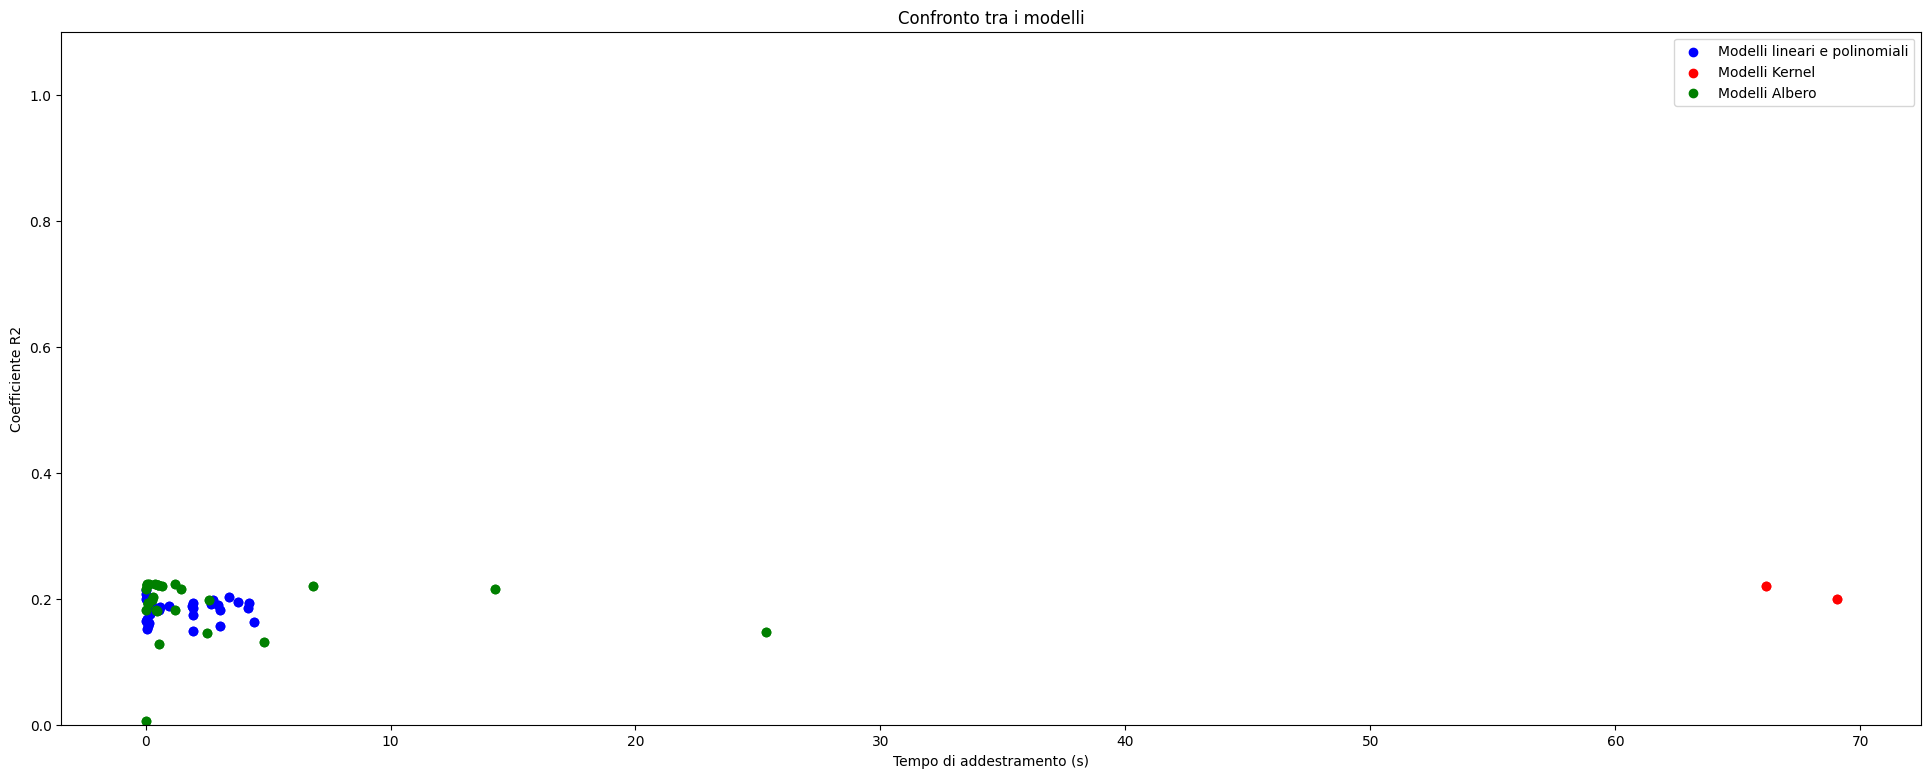

In [62]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_models_gs_res, linear_models_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')

krm_models = pd.concat([krm_gs_res, krm_gs_res], axis=0)
scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')

tree_models = pd.concat([tree_gs_res, tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()


### test predizione

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


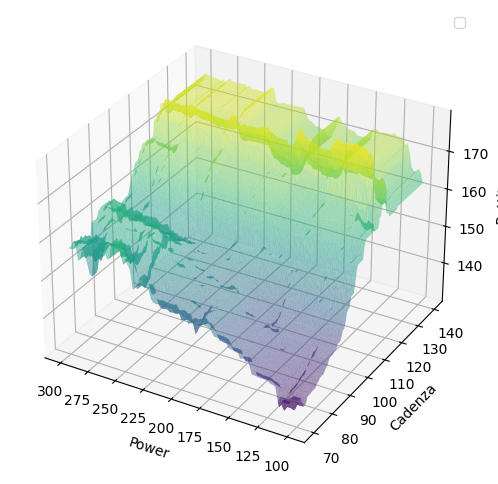

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_model_on_data(X, y, model=None):
    if X.shape[1] != 2:
        raise ValueError("La funzione supporta solo dati bidimensionali (due feature per campione).")
    
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(111, projection='3d')
    power = X[:, 0]
    cadenza = X[:, 1]
    battito = y
    #ax.scatter(power, cadenza,battito, c='blue', linewidth=0.5)
    
    if model is not None:
        xlim_power, ylim_cadenza = plt.xlim(), plt.ylim()
        line_power = np.linspace(100, 300, 100)
        line_cadenza = np.linspace(70, 140, 100)
        combined = np.array(np.meshgrid(line_power, line_cadenza)).T.reshape(-1, 2)
        predicted = model.predict(combined)
        ax.plot_trisurf(combined[:, 0], combined[:, 1], predicted, alpha=0.5, cmap='viridis', linewidth=0.2)
        
    ax.set_xlabel('Power')
    ax.set_ylabel('Cadenza')
    ax.set_zlabel('Battito')
    ax.invert_xaxis()
    plt.grid()
    plt.legend()
    plt.show()  # Add this line to display the plot.

# Assuming you have X_val and y_val defined and tree_gs is the trained model.
X_val_array = X_val.to_numpy()
plot_model_on_data(X_val_array, y_val, tree_gs)


In [64]:
pd.DataFrame({'Feature': X_hr.columns, 'Weight': tree_gs.best_estimator_.named_steps['regressor'].feature_importances_})

Feature  Weight
0  power(watts)   12118
1  cadence(rpm)   11484

In [65]:
tree_gs.predict(np.array([280, 110]).reshape(1, -1))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([169.6939592])

### Reti neurali

Abbiamo deciso di provare anche le reti neurali per la previsione del battito. In particolare abbiamo provato due tipi di reti neurali:
- *Multi Layer Perceptron* (sklearn)
- *Adam Neural Network* (keras)

In [127]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:       273.81
       Relative error:     8.88674%
R-squared coefficient:       0.2175


In [128]:
pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.454232      8.076204          0.09513        0.123496   

  param_regressor__activation param_regressor__alpha  \
0                        relu                   0.01   

  param_regressor__batch_size param_regressor__hidden_layer_sizes  \
0                         128                          (256, 256)   

  param_regressor__max_iter  \
0                      2000   

                                              params  split0_test_score  \
0  {'regressor__activation': 'relu', 'regressor__...           0.220127   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.204465           0.211358            0.21923           0.201238   

   mean_test_score  std_test_score  rank_test_score  
0         0.211284          0.0076                1

In [129]:
pd.DataFrame({'Feature': X_hr.columns, 'Weight': model.best_estimator_.named_steps['regressor'].coefs_[0].mean(axis=1)})

Feature    Weight
0  power(watts)  0.002374
1  cadence(rpm)  0.008549

### test predizione

## Previsione Potenza

La previsione della potenza è del tutto identica a quella fatta per il battito. La differenza sta nel fatto che il training set è differente. In particolare, per la previsione della potenza, abbiamo deciso di droppare anche `power_zone` per lo stesso motivo per cui abbiamo droppato `hr_zone` per la previsione del battito.

In [130]:
X_watt = combined_df.drop(['power(watts)','distance(m)','altitude(m)','speed(m/s)','avg_power(watts)','time_since_start(s)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_watt = combined_df['avg_power(watts)']
X_train, X_val, y_train, y_val = train_test_split(X_watt, y_watt, test_size=1/3, random_state=42)

### Regressione con modelli lineari e polinomiali

In [74]:
linear_gs = get_trained_model('linear', X_train, y_train)
print_eval(X_val, y_val, linear_gs)
linear_gs_res=pd.DataFrame(linear_gs.cv_results_).sort_values("mean_test_score", ascending=False)
linear_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.759e+07, tolerance: 2.040e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qb

   Mean squared error:       5167.8
       Relative error:    97.51265%
R-squared coefficient:       0.2658


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2        0.019126      0.001492         0.001800        0.000245   
1        0.011860      0.000665         0.001900        0.000374   
0        0.011446      0.001953         0.001900        0.000490   
23       4.197213      0.053078         0.002503        0.000002   
14       3.066533      0.036592         0.002404        0.000202   
5        1.974490      0.013822         0.001701        0.000246   
26       2.334550      0.160261         0.002503        0.000316   
22       4.372399      0.011799         0.002401        0.000200   
17       1.804315      0.040597         0.002201        0.000400   
13       3.067909      0.022610         0.002301        0.000246   
8        1.314841      0.080336         0.001902        0.000201   
4        2.025286      0.020166         0.001702        0.000244   
21       4.365615      0.021793         0.002604        0.000377   
12       3.057501      0.040606         0.002402        0.000581   
3        2.022531      0.007592         0.001602        0.000202   
25       2.972883      0.202219         0.002203        0.000402   
16       1.330766      0.072207         0.002205        0.000245   
24       4.689573      0.162199         0.002203        0.000245   
29       0.620458      0.073205         0.002202        0.000245   
20       0.087805      0.001883         0.002002        0.000315   
15       3.112578      0.022979         0.002503        0.000002   
11       0.042845      0.001083         0.002200        0.000400   
7        0.496704      0.015296         0.001604        0.000198   
28       0.342272      0.010333         0.002004        0.000317   
6        1.989200      0.036735         0.001802        0.000243   
27       4.509543      0.036137         0.002302        0.000246   
19       0.145434      0.006189         0.001902        0.000491   
18       3.117962      0.025201         0.002101        0.000200   
10       0.063431      0.000704         0.001501        0.000316   
9        2.021060      0.026235         0.001600        0.000200   

   param_poly__degree     param_regressor         param_std  \
2                   5  LinearRegression()  StandardScaler()   
1                   4  LinearRegression()  StandardScaler()   
0                   3  LinearRegression()  StandardScaler()   
23                  5        ElasticNet()  StandardScaler()   
14                  4        ElasticNet()  StandardScaler()   
5                   3        ElasticNet()  StandardScaler()   
26                  5        ElasticNet()  StandardScaler()   
22                  5        ElasticNet()  StandardScaler()   
17                  4        ElasticNet()  StandardScaler()   
13                  4        ElasticNet()  StandardScaler()   
8                   3        ElasticNet()  StandardScaler()   
4                   3        ElasticNet()  StandardScaler()   
21                  5        ElasticNet()  StandardScaler()   
12                  4        ElasticNet()  StandardScaler()   
3                   3        ElasticNet()  StandardScaler()   
25                  5        ElasticNet()  StandardScaler()   
16                  4        ElasticNet()  StandardScaler()   
24                  5        ElasticNet()  StandardScaler()   
29                  5        ElasticNet()  StandardScaler()   
20                  4        ElasticNet()  StandardScaler()   
15                  4        ElasticNet()  StandardScaler()   
11                  3        ElasticNet()  StandardScaler()   
7                   3        ElasticNet()  StandardScaler()   
28                  5        ElasticNet()  StandardScaler()   
6                   3        ElasticNet()  StandardScaler()   
27                  5        ElasticNet()  StandardScaler()   
19                  4        ElasticNet()  StandardScaler()   
18                  4        ElasticNet()  StandardScaler()   
10                  3        ElasticNet()  StandardScaler()   
9    

### Regressione con funzioni kernel

In [75]:
kernel_gs = get_trained_model('kernel', X_train, y_train)
print_eval(X_val, y_val, kernel_gs)
kernel_gs_res=pd.DataFrame(kernel_gs.cv_results_).sort_values("mean_test_score", ascending=False)
kernel_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:       5119.0
       Relative error:    96.29720%
R-squared coefficient:      0.27274


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      62.541069      0.650825         1.885633        0.011420   
0      68.458889      1.546432         3.076309        0.042393   

                                   param_regressor param_regressor__alpha  \
1  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   
0  KernelRidge(alpha=0.1, gamma=0.1, kernel='rbf')                    0.1   

  param_regressor__degree param_regressor__kernel         param_std  \
1                     NaN                     rbf  StandardScaler()   
0                       3                    poly  StandardScaler()   

  param_regressor__gamma                                             params  \
1                    0.1  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   
0                    NaN  {'regressor': KernelRidge(alpha=0.1, gamma=0.1...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.292511           0.269357           0.278508           0.280922   
0           0.277879           0.249736           0.263853           0.265881   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.275182         0.279296        0.007663                1  
0           0.256676         0.262805        0.009446                2

### Regressione con alberi

In [76]:
watt_tree_gs = get_trained_model('tree', X_train, y_train)
print_eval(X_val, y_val, watt_tree_gs, tree=True)
watt_tree_gs_res=pd.DataFrame(watt_tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
watt_tree_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 29117, number of used features: 2
[LightGBM] [Info] Start training from score 173.504654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundatio

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 36397, number of used features: 2
[LightGBM] [Info] Start training from score 173.487375
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
   Mean squared error:       4958.2
    RMSPE:       4.9653
R-squared coefficient:      0.29558


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       0.465942      0.004616         0.024175        0.001102   
19       0.055330      0.003171         0.004203        0.000244   
12       0.433940      0.013827         0.024472        0.001164   
17       0.056933      0.003239         0.004820        0.000594   
27       0.119373      0.002557         0.002716        0.000392   
15       0.040844      0.002716         0.003903        0.000664   
22       1.132579      0.008196         0.008805        0.000749   
6        9.966093      0.080007         0.415930        0.005623   
10       0.355519      0.038513         0.019407        0.001243   
5        0.988944      0.002166         0.041961        0.000229   
16       0.265272      0.007831         0.019403        0.000530   
18       0.437880      0.026263         0.025919        0.000377   
4        5.230198      0.029182         0.193120        0.009740   
3        0.522713      0.007440         0.019510        0.000451   
28       1.086588      0.028212         0.008014        0.000459   
20       0.448065      0.010454         0.022937        0.000570   
24       2.854053      0.145152         0.021790        0.001661   
29       0.269800      0.007378         0.003537        0.000322   
0        0.008705      0.000678         0.001100        0.000200   
1        0.014055      0.000476         0.001487        0.000319   
8       16.485460      0.143487         0.669170        0.017938   
7        1.619973      0.012853         0.065865        0.000685   
13       0.061673      0.001446         0.003522        0.000041   
11       0.066735      0.001844         0.003719        0.000373   
9        0.061486      0.001241         0.004001        0.000448   
26       6.838786      0.335193         0.045085        0.001440   
31       0.739481      0.084134         0.005520        0.000659   
2        0.021031      0.000318         0.001300        0.000245   
30       2.584471      0.052968         0.020541        0.000913   
32       3.846440      0.185956         0.028097        0.001381   
23       0.290361      0.009079         0.003729        0.000230   
25       0.571193      0.088273         0.005202        0.000246   
21       0.120686      0.003479         0.002562        0.000231   

                                      param_regressor  \
14  LGBMRegressor(learning_rate=0.01, max_depth=15...   
19  LGBMRegressor(learning_rate=0.01, max_depth=15...   
12  LGBMRegressor(learning_rate=0.01, max_depth=15...   
17  LGBMRegressor(learning_rate=0.01, max_depth=15...   
27  XGBRegressor(base_score=None, booster=None, ca...   
15  LGBMRegressor(learning_rate=0.01, max_depth=15...   
22  XGBRegressor(base_score=None, booster=None, ca...   
6                             RandomForestRegressor()   
10  LGBMRegressor(learning_rate=0.01, max_depth=15...   
5                             RandomForestRegressor()   
16  LGBMRegressor(learning_rate=0.01, max_depth=15...   
18  LGBMRegressor(learning_rate=0.01, max_depth=15...   
4                             RandomForestRegressor()   
3                             RandomForestRegressor()   
28  XGBRegressor(base_score=None, booster=None, ca...   
20  LGBMRegressor(learning_rate=0.01, max_depth=15...   
24  XGBRegressor(base_score=None, booster=None, ca...   
29  XGBRegressor(base_score=None, booster=None, ca...   
0                             DecisionTreeRegressor()   
1                             DecisionTreeRegressor()   
8                             RandomForestRegressor()   
7                             RandomForestRegressor()   
13  LGBMRegressor(learning_rate=0.01, max_depth=15...   
11  LGBMRegressor(learning_rate=0.01, max_depth=15...   
9   LGBMRegressor(learning_rate=0.01, max_depth=15...   
26  XGBRegressor(base_score=None, booster=None, ca...   
31  XGBRegressor(base_score=None, booster=None, ca...   
2                             DecisionTreeRegressor()   
30  XGBRegressor(base_score=None, boos

### Confronto fra modelli

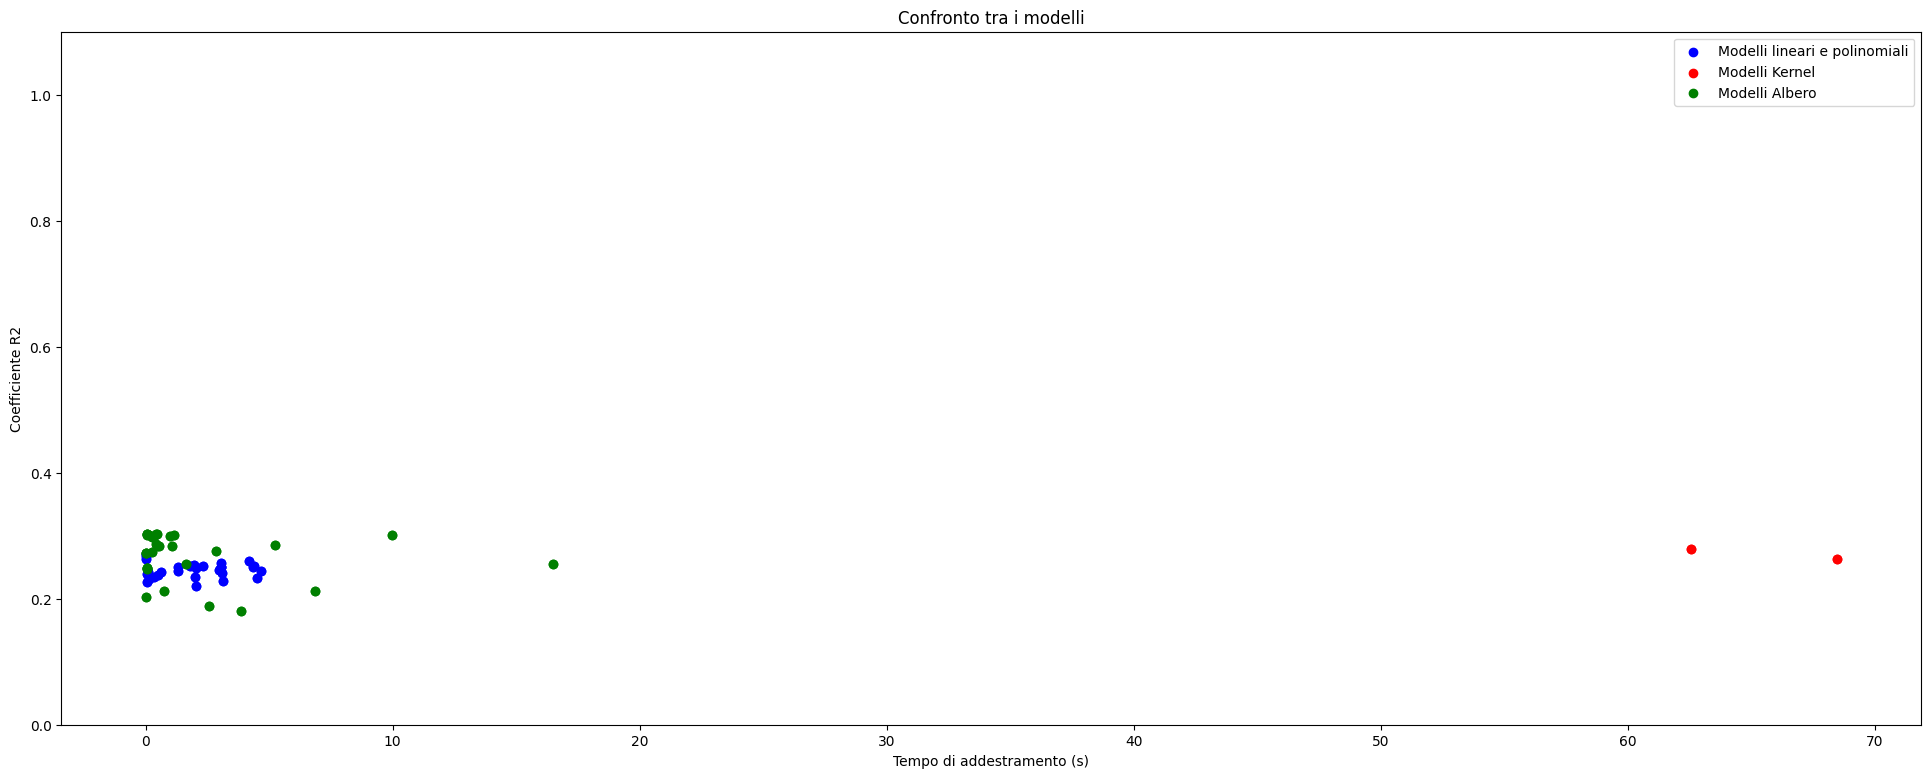

In [131]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_gs_res, linear_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')

krm_models = pd.concat([kernel_gs_res, kernel_gs_res], axis=0)
scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')

tree_models = pd.concat([watt_tree_gs_res, watt_tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()


### test predizione

In [78]:
watt_tree_gs.predict(np.array([140,90]).reshape(1, -1))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([135.53385662])

### Reti neurali

In [132]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:       5070.9
       Relative error:    96.64151%
R-squared coefficient:      0.27957


In [133]:
pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     407.305787     277.63175         1.580506        0.673336   

  param_regressor__activation param_regressor__alpha  \
0                        relu                   0.01   

  param_regressor__batch_size param_regressor__hidden_layer_sizes  \
0                         128                          (256, 256)   

  param_regressor__max_iter  \
0                      2000   

                                              params  split0_test_score  \
0  {'regressor__activation': 'relu', 'regressor__...           0.296617   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.270657           0.276829           0.292084           0.278436   

   mean_test_score  std_test_score  rank_test_score  
0         0.282925         0.00979                1

In [134]:
pd.DataFrame({'Feature': X_watt.columns, 'Weight': model.best_estimator_.named_steps['regressor'].coefs_[0].mean(axis=1)})

Feature    Weight
0  heart_rate(bpm)  0.048013
1     cadence(rpm) -0.001153

# Classificazione

Di seguito sono riportate le operazioni fatte per la classificazione. In particolare si è deciso di utilizzare il modello *Decision Tree Classifier*. 

Nelle celle sottostanti vengono definite delle funzioni che consentono di rappresentare graficamente le varie zone di battito e potenza in funzione del tempo trascorso in allenamento.

In [82]:
import matplotlib.patches as mpatches

def plot_scatter_zones_per_training(feature, zone):
    color_map = {1: "darkblue", 2: "blue", 3: "aquamarine", 4: "green", 5: "yellow", 6: "orange", 7: "red"}
    
    grouped_df = combined_df.groupby(combined_df.index.date)
    
    legend_patches = [mpatches.Patch(color=color, label=f'Zone {zone}') for zone, color in color_map.items()]

    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)

    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].scatter(data['time_since_start(s)'], data[feature], c=data[zone].map(color_map), s=5)
        axes[i].set_title(f'Training {allenamento}')

    fig.suptitle(f'{feature} zones for each training')
    plt.xlabel('time_since_start(s)')
    plt.ylabel(feature)
    plt.legend(handles=legend_patches, title=f'{feature} zone')
    
    plt.show()


In [83]:
def plot_zones_bars_per_training(zone):
    grouped_df = combined_df.groupby(combined_df.index.date)
    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)
    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].barh(data[zone].value_counts().index, data[zone].value_counts().values)
        axes[i].set_title(f'Training {allenamento}')

    plt.xlabel('time_since_start(s)')
    plt.ylabel(zone)


## Classificazione della potenza

Abbiamo deciso di classificare la potenza sulla base della potenza istananea in funzione del tempo trascorso. Ecco perché abbiamo considerato come feature solo
- `power(watts)`
- `time_since_start(s)`

In [135]:
X = combined_df[["time_since_start(s)", "power(watts)"]]
y = combined_df['pwr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Dal grafico seguente si nota che la maggior parte del tempo ci si trova nelle zone 1 e 2, con dei picchi su quelle più alte. Inoltre si nota che negli allenamenti del 16-02-2020 e del 05-07-2020 si è passato pochissimo tempo nella zona 7 poiché in essi vi era molta salita, dunque i grafici sono compatibili con quanto detto in precedenza.

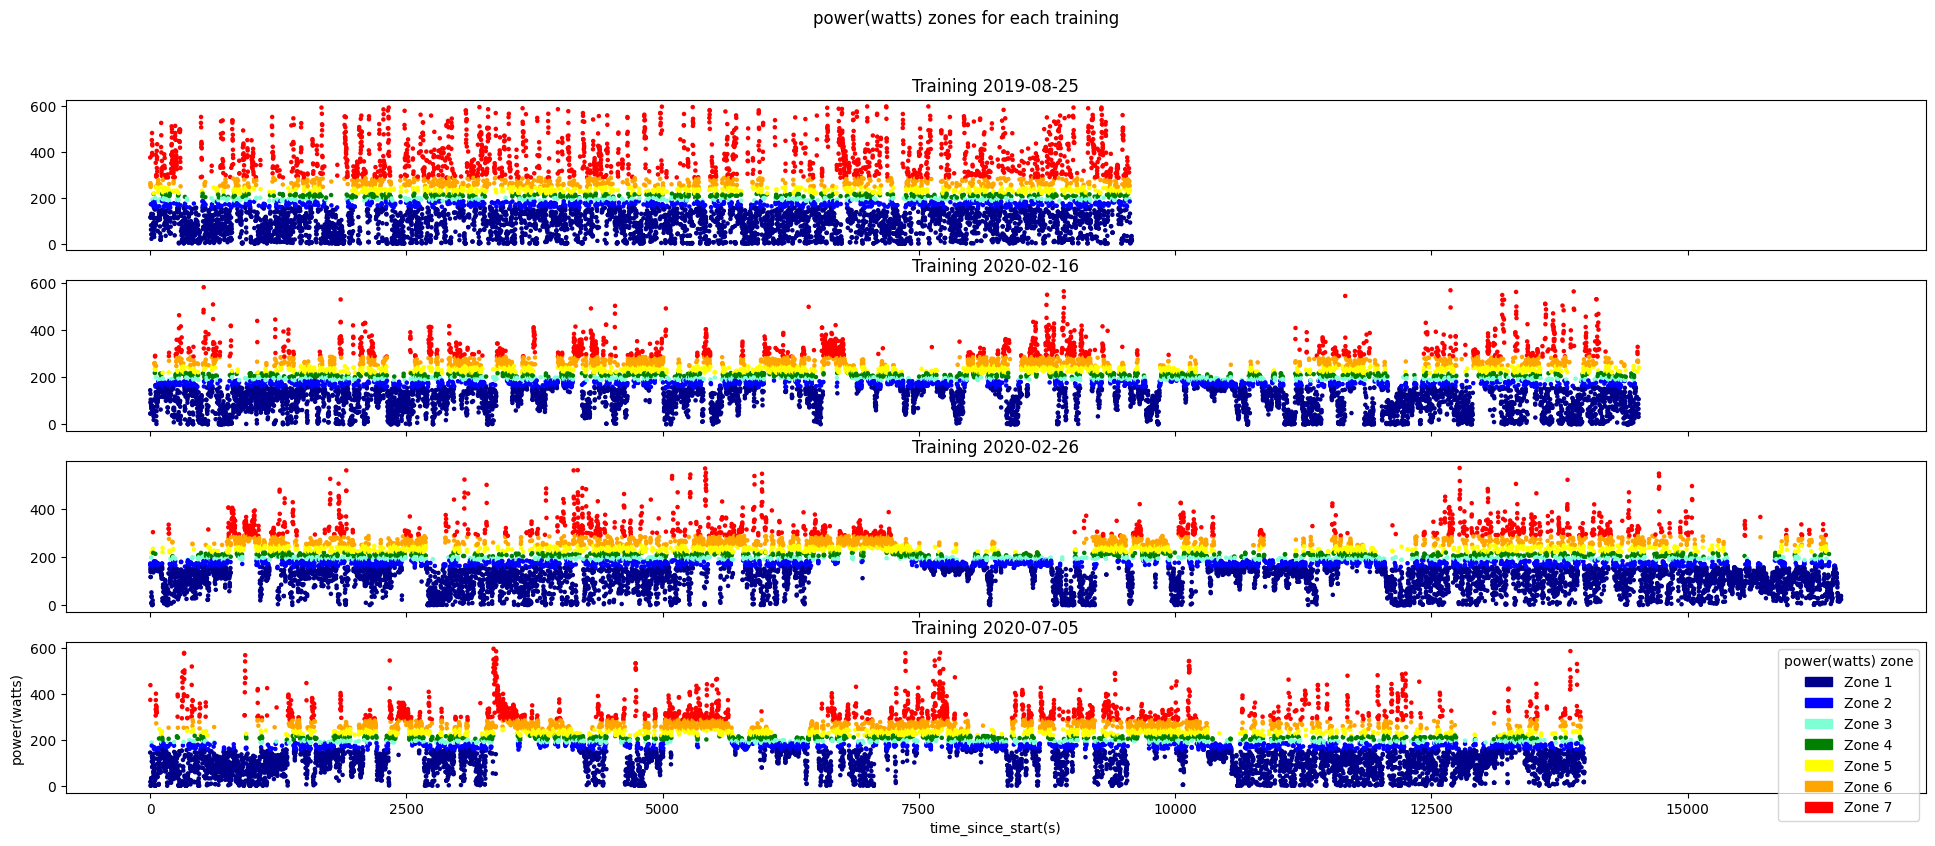

In [85]:
plot_scatter_zones_per_training('power(watts)', 'pwr_zone')

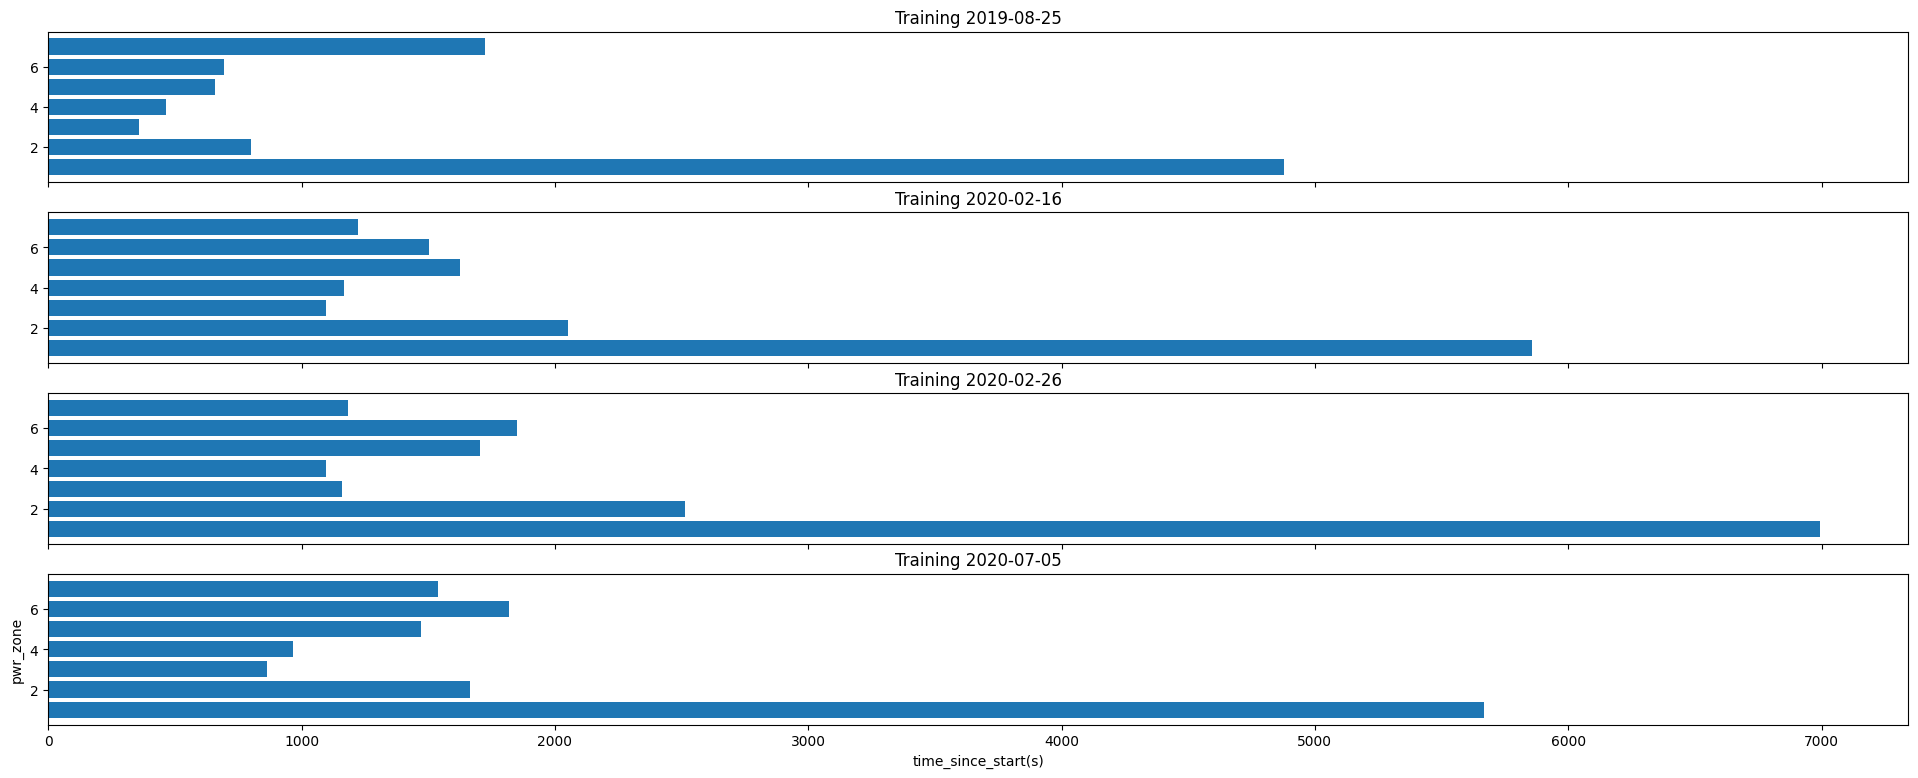

In [86]:
plot_zones_bars_per_training('pwr_zone')

Di seguito è riportata la pipeline per la classificazione della potenza. Come anticipato si è deciso di utilizzare il modello *Decision Tree Classifier*. La pipeline è composta da:
- `StandardScaler`: la grid search valuterà se è meglio standardizzare o meno i dati
- `criterion`: criterio con cui valutare la bontà di uno split
- `max_depth`: massima profondità dell'albero
- `splitter`: la strategia usata per scegliere lo split migliore su ogni nodo
- `min_samples_leaf`: numero minimo di campioni necessari per essere una foglia
- `min_samples_split`: numero minimo di campioni necessari per effettuare uno split 
- `max_features`: numero di features da considerare per la ricerca dello split migliore

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7500 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3382 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

|--- power(watts) <= 186.50
|   |--- time_since_start(s) <= 12047.50
|   |   |--- time_since_start(s) <= 3700.50
|   |   |   |--- power(watts) <= 157.50
|   |   |   |   |--- class: 1
|   |   |   |--- power(watts) >  157.50
|   |   |   |   |--- class: 2
|   |   |--- time_since_start(s) >  3700.50
|   |   |   |--- power(watts) <= 157.50
|   |   |   |   |--- class: 1
|   |   |   |--- power(watts) >  157.50
|   |   |   |   |--- class: 2
|   |--- time_since_start(s) >  12047.50
|   |   |--- time_since_start(s) <= 15386.50
|   |   |   |--- power(watts) <= 157.50
|   |   |   |   |--- class: 1
|   |   |   |--- power(watts) >  157.50
|   |   |   |   |--- class: 2
|   |   |--- time_since_start(s) >  15386.50
|   |   |   |--- time_since_start(s) <= 15580.50
|   |   |   |   |--- class: 1
|   |   |   |--- time_since_start(s) >  15580.50
|   |   |   |   |--- power(watts) <= 157.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- power(watts) >  157.50
|   |   |   |   |   |--- class: 2
|--- pow

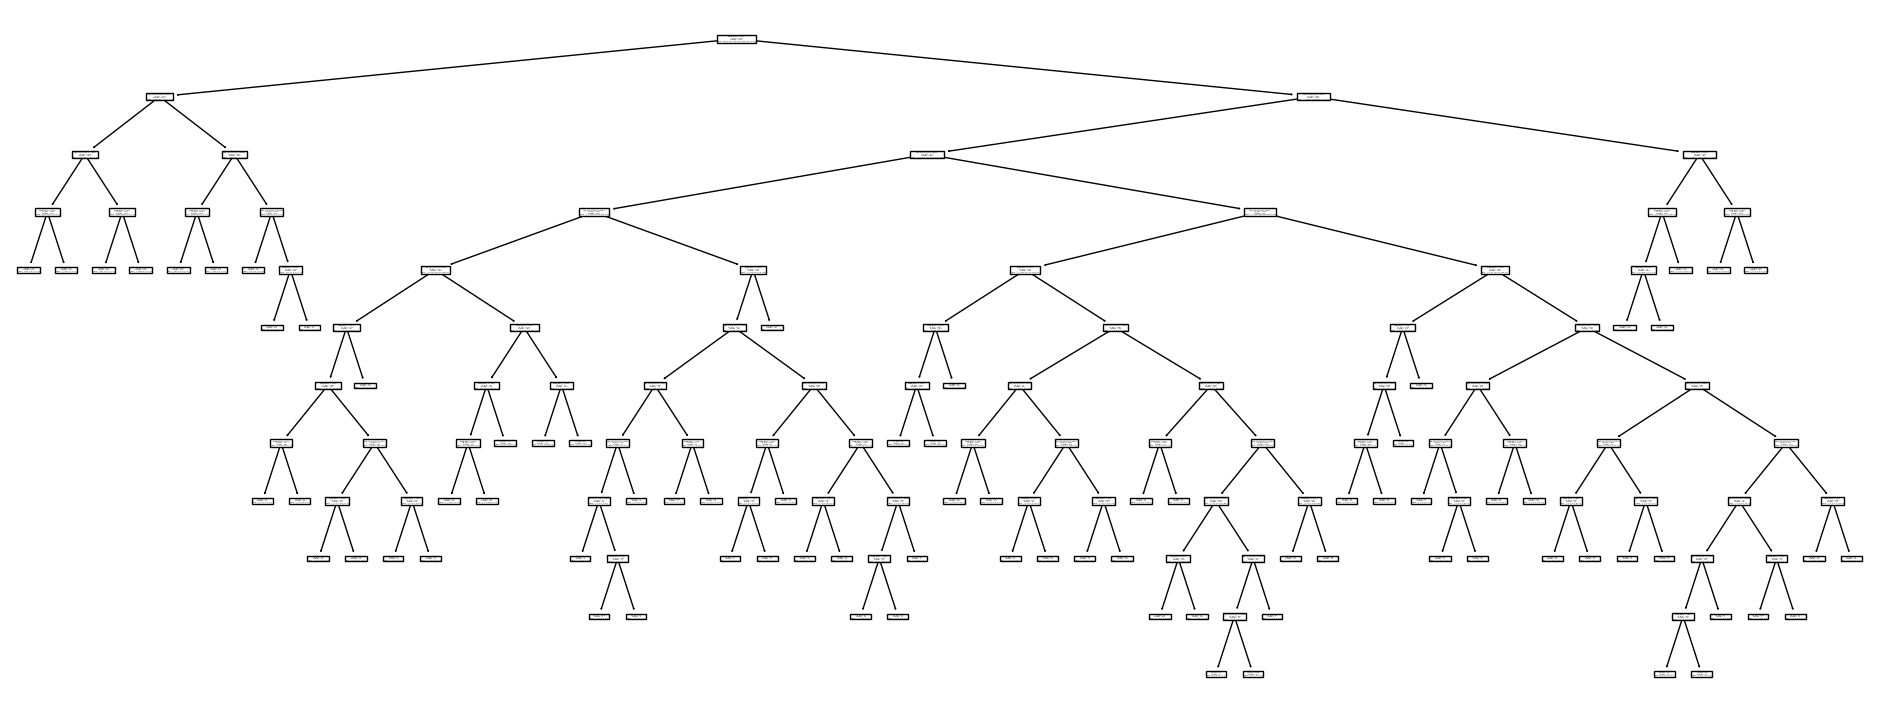

In [87]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

In [136]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPClassifier())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)


   Mean squared error:    0.0086268
       Relative error:     0.25816%
R-squared coefficient:      0.99825


## Classificazione dei battiti

La classificazione dei battiti è del tutto equivalente a quella della potenza.

In [137]:
X = combined_df[["time_since_start(s)", "heart_rate(bpm)"]]
y = combined_df['hr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

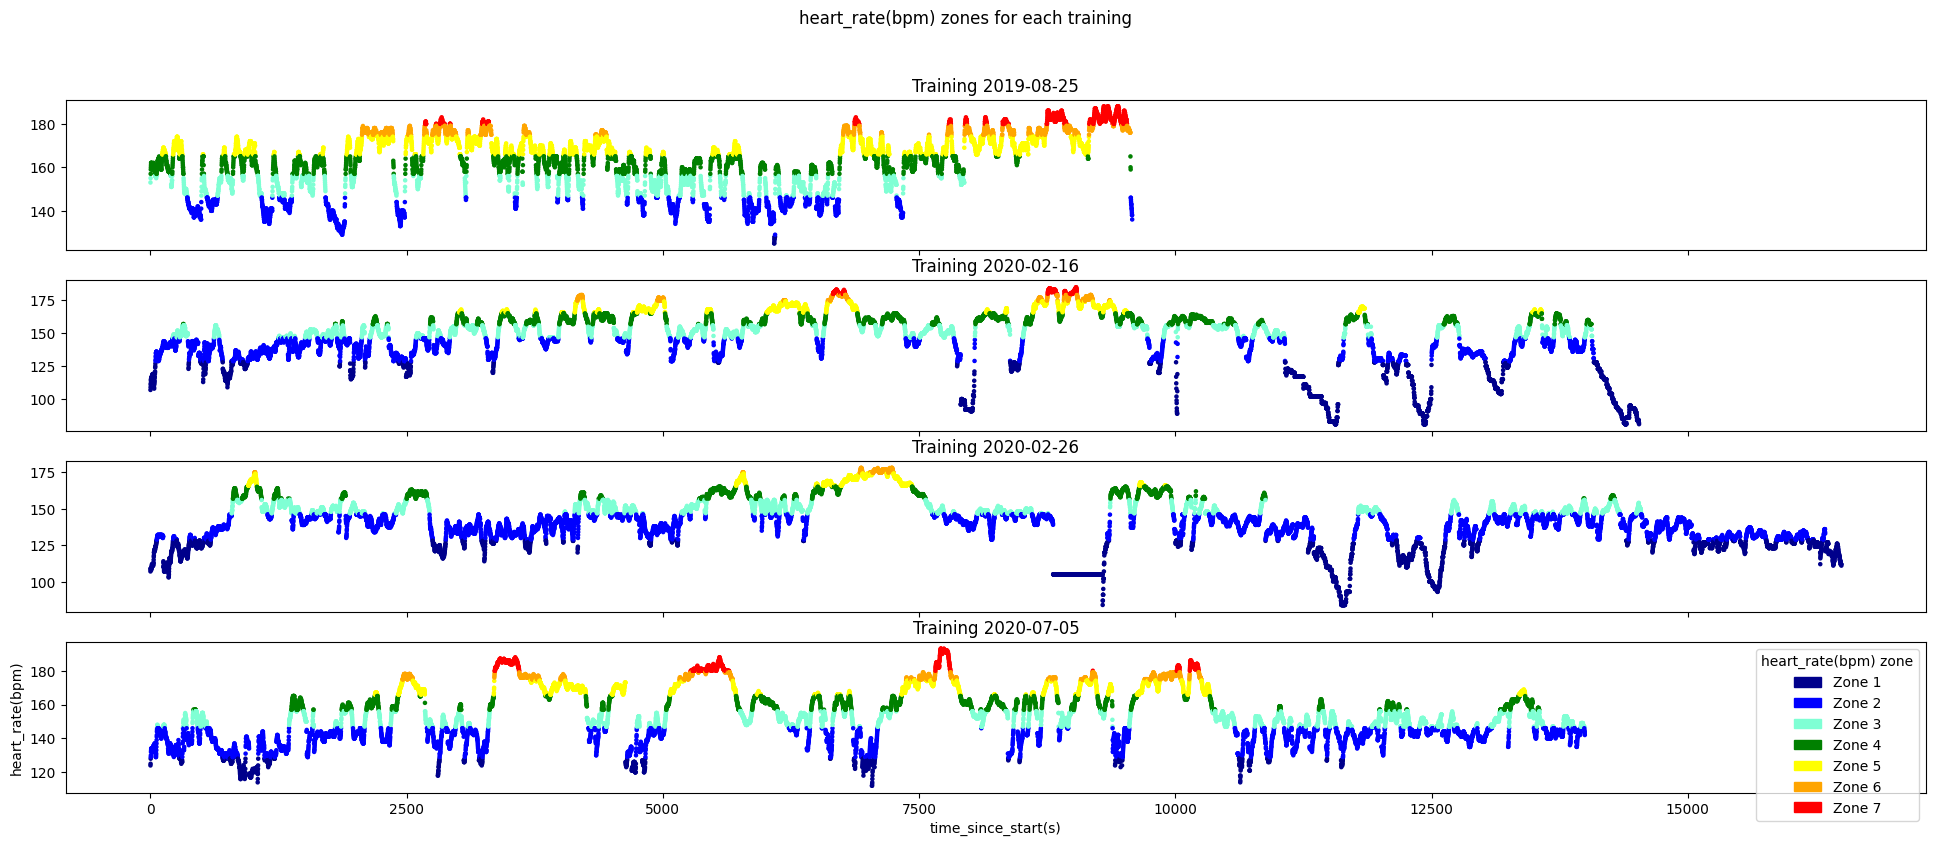

In [89]:
plot_scatter_zones_per_training('heart_rate(bpm)', 'hr_zone')

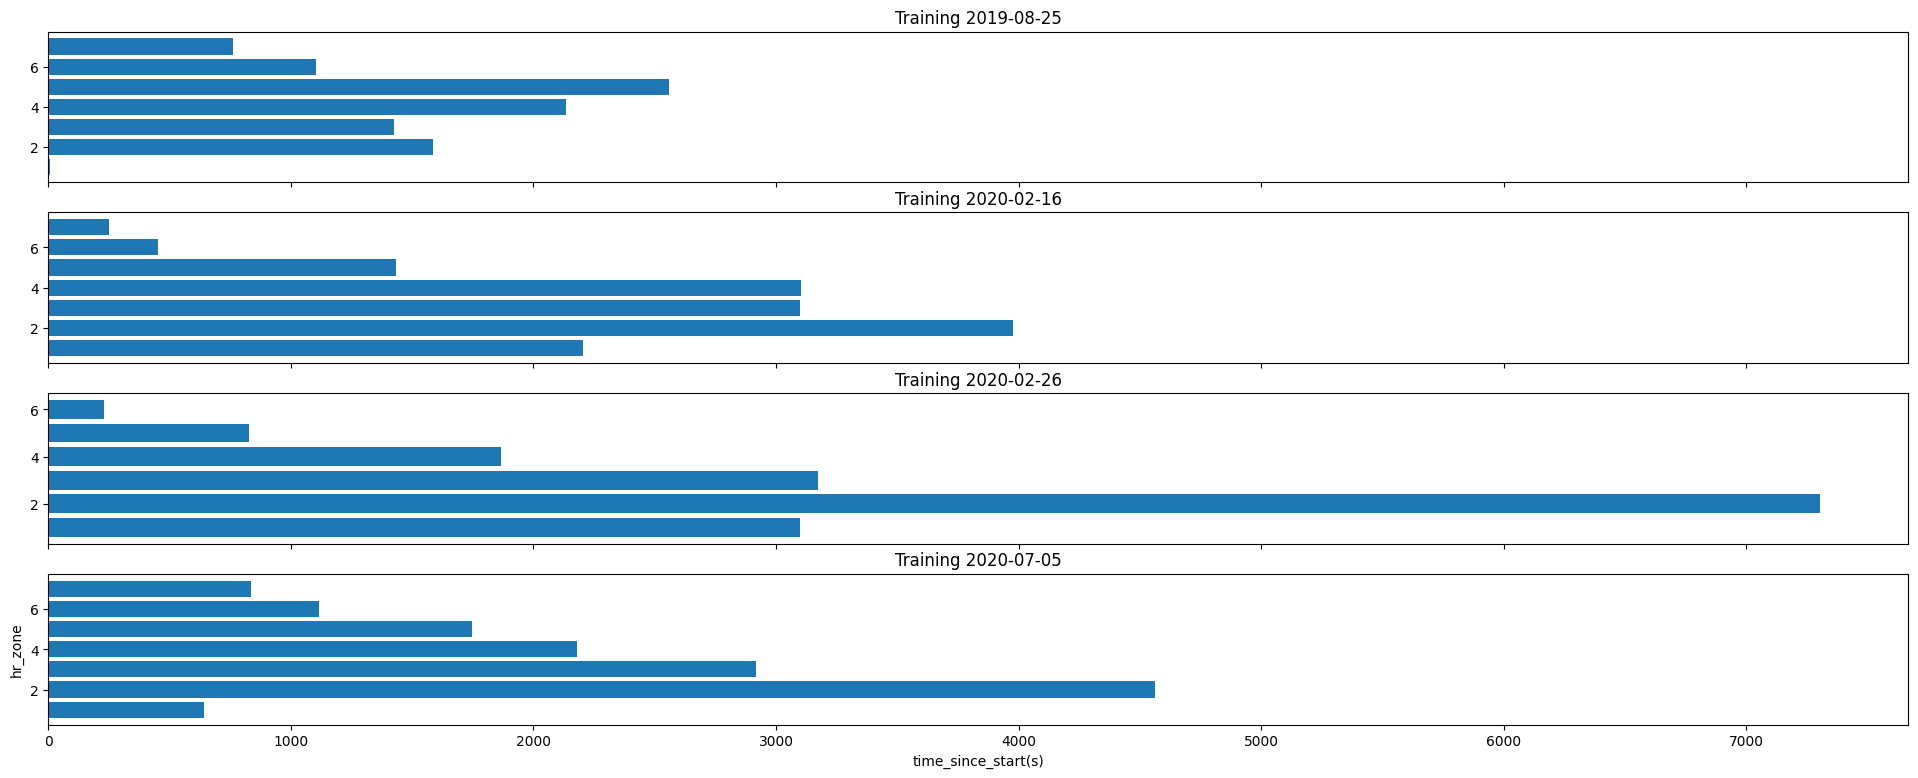

In [90]:
plot_zones_bars_per_training('hr_zone')

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7500 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3450 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

|--- heart_rate(bpm) <= 146.50
|   |--- time_since_start(s) <= 7905.50
|   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |--- class: 1
|   |   |--- heart_rate(bpm) >  128.50
|   |   |   |--- class: 2
|   |--- time_since_start(s) >  7905.50
|   |   |--- time_since_start(s) <= 16174.50
|   |   |   |--- time_since_start(s) <= 12634.50
|   |   |   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- heart_rate(bpm) >  128.50
|   |   |   |   |   |--- class: 2
|   |   |   |--- time_since_start(s) >  12634.50
|   |   |   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- heart_rate(bpm) >  128.50
|   |   |   |   |   |--- class: 2
|   |   |--- time_since_start(s) >  16174.50
|   |   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |   |--- class: 1
|   |   |   |--- heart_rate(bpm) >  128.50
|   |   |   |   |--- class: 2
|--- heart_rate(bpm) >  146.50
|   |--- time_since_start(s) <= 10362.50
|   |   |--- heart_rate(bpm) 

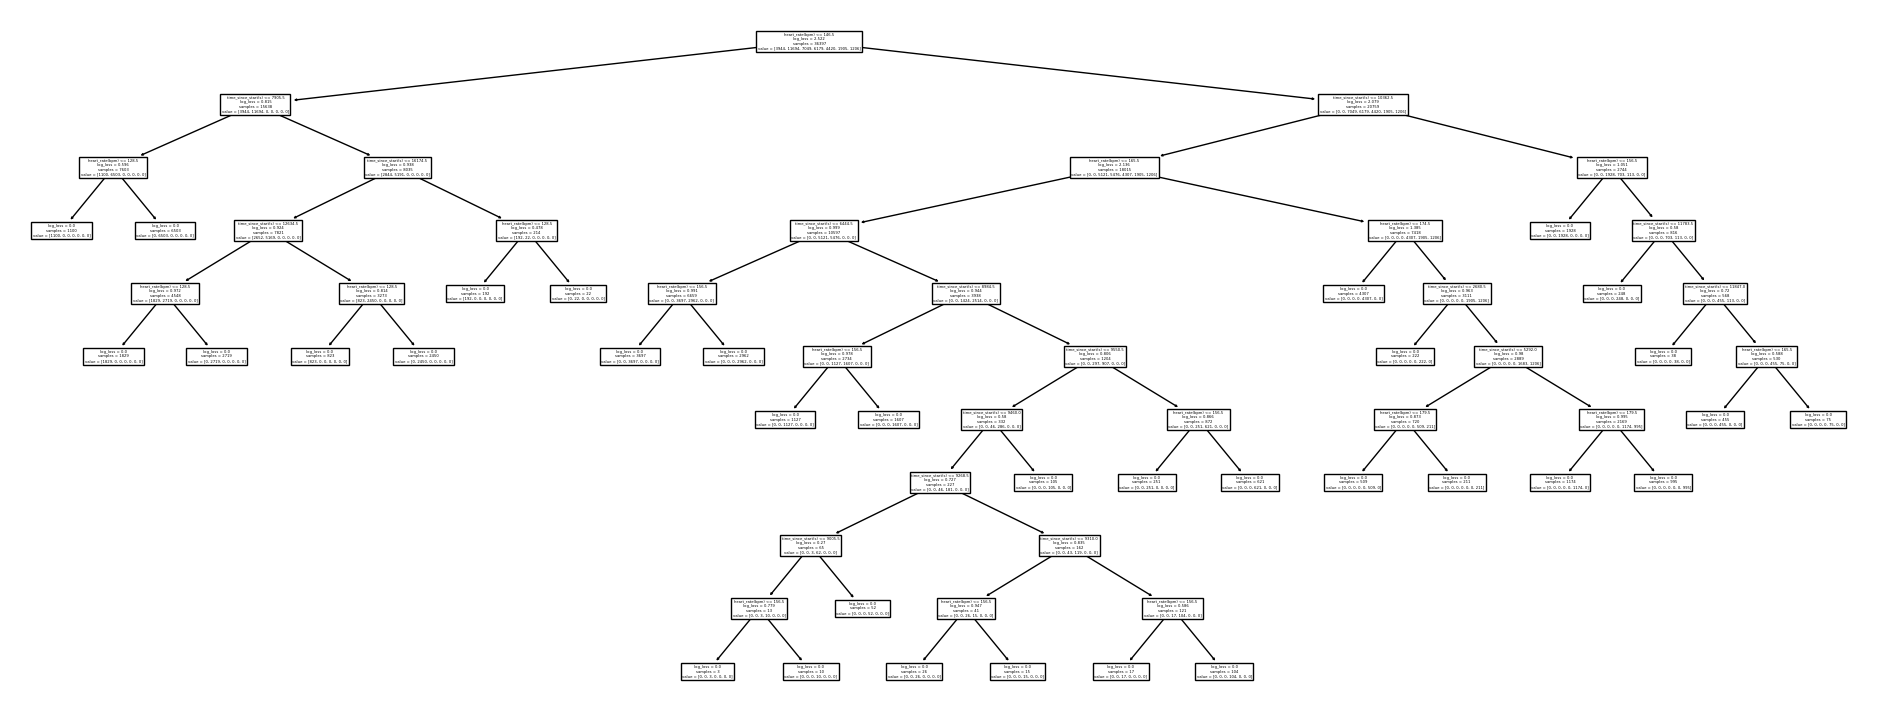

In [91]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

In [138]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPClassifier())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=1)
model.fit(X_train, y_train)
print_eval(X_test, y_test, model)


   Mean squared error:     0.002143
       Relative error:     0.10715%
R-squared coefficient:      0.99912


# Flask

Di seguito è riportato il codice di generazione di uno script python (*garmin_flask.py*) generante un file html che consente di immettere i dati di un allenamento e di ottenere la previsione del battito e della potenza a partire dai modelli migliori.

In [92]:
import os
import pickle
import flask

Il primo passo è generare dei folder su cui salvare i file necessari per la generazione del file html. In particolare vengono generati i seguenti folder:
- `templates`: contiene il file html generato
- `models`: contiene i modelli utilizzati per la previsione
- `datasets`: contiene i dataset utilizzati per la previsione

In [93]:
if not os.path.isdir("templates"):
  os.mkdir("templates")

if not os.path.isdir("models"):
  os.mkdir("models")

if not os.path.isdir("datasets"):
  os.mkdir("datasets")

Tramite `pickle` vengono salvati i modelli migliori per la previsione del battito e della potenza. Come visto sopra, i modelli migliori in entrambi i casi sono gli alberi di regressione.
In particolare
- per la previsione del battito (indica i parametri)
- per la previsione della potenza (indica i parametri)

In [94]:
with open("models/hr_model.bin", "wb") as f:
    pickle.dump(tree_gs.best_estimator_, f)

with open("models/watt_model.bin", "wb") as f:
    pickle.dump(watt_tree_gs.best_estimator_, f)

with open("datasets/hr_dataset.pkl", "wb") as f:
    pickle.dump(X_hr, f)

with open("datasets/watt_dataset.pkl", "wb") as f:
    pickle.dump(X_watt, f)

Da qui si comincia a scrivere sul file `garmin_flask.py`, importando le librerie necessarie al suo corretto funzionamento.

In [95]:
%%writefile garmin_flask.py
import os.path
import pickle
from flask import Flask, request, render_template
import numpy as np

Overwriting garmin_flask.py


Con l'attributo `-a` (append) di `%%writefile` è possibile aggiungere codice al file senza sovrascriverlo.

In [96]:
%%writefile -a garmin_flask.py

app = Flask(__name__)
app.debug = True

Appending to garmin_flask.py


In questa parte è definita la logica con cui rispondere alle richieste POST dell'utente dalla pagina HTML. In particolare, dopo aver deserializzato i dataset, se viene inviata una richiesta dalla card `hr` (corrispondente alla previsione del battito), si esegue quanto segue:
- si estraggono i dati inseriti dall'utente
  - a tal proposito occorre fare un cast a tipo int64 o float64 in base al tipo dichiarato nel dataset
- si inseriscono in una lista `inputs`
- si predice il battito corrispondente ai dati inseriti
  - occorre fare un reshape dei dati inseriti per poterli dare in pasto al modello

Completate queste operazioni si ricarica la pagina passandole il dato predetto `response`, la pagina si occuperà di inserirlo nel campo corrispondente.

In [97]:
%%writefile -a garmin_flask.py

@app.route("/", methods=["GET", "POST"])
def index():
    
    with open('datasets/hr_dataset.pkl', 'rb') as f:
        X_hr = pickle.load(f)
    with open('datasets/watt_dataset.pkl', 'rb') as f:
        X_watt = pickle.load(f)

    if request.method == "POST":
        card = request.form.get("card")

        if card == "hr":
            inputs = []
            for column_name, dtype in X_hr.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/hr_model.bin", "rb") as f:
                hr_model = pickle.load(f)
            response = hr_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", hr_pred=response, X_hr=X_hr, X_watt=X_watt)

        elif card == "watt":
            inputs = []
            for column_name, dtype in X_watt.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/watt_model.bin", "rb") as f:
                watt_model = pickle.load(f)
            response = watt_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", w_pred=response, X_hr=X_hr, X_watt=X_watt)

    return render_template("index.html", X_hr=X_hr, X_watt=X_watt)

Appending to garmin_flask.py


In [98]:
%%writefile -a garmin_flask.py

if __name__ == '__main__':
  app.run()

Appending to garmin_flask.py


Di seguito è riportata la pagina HTML che consente di inserire i dati e di ottenere la previsione del battito e della potenza.
Questa viene salvata all'interno di `templates/index.html`.

In [99]:
%%writefile templates/index.html

<!doctype html>
<html lang="en">

<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Bootstrap demo</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet"
    integrity="sha384-9ndCyUaIbzAi2FUVXJi0CjmCapSmO7SnpJef0486qhLnuZ2cdeRhO02iuK6FUUVM" crossorigin="anonymous">
</head>

<body class="d-flex flex-column vh-100" data-bs-theme="dark">
  <header class="d-flex justify-content-center shadow py-3">
      <h1>data intensive</h1>
  </header>
  <div class="d-flex align-items-center justify-content-center h-100">
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione battiti</h5>
        <form method="POST" action="">
          {% for column in X_hr.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="hr">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ hr_pred }}</b></p>
      </div>
    </div>
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione potenza</h5>
        <form method="POST" action="">
          {% for column in X_watt.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="watt">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ w_pred }}</b></p>
      </div>
    </div>
  </div>
</body>

</html>


Overwriting templates/index.html
